### Выполненное тестовое задание

 **ОГЛАВЛЕНИЕ**
* Разделы:
    * [0. Подготовка данных.](#load)
    -------
    * Задача:
    * [1. Из 2х таблиц впр по коду сделать анализ по месяцам какие парки и из какой отрасли превалируют](#task1)
     * [1.1 Вывод по задаче 1](#end_task1)
    -------
    * [2. Парки разбить на сегменты по размеру парка 0-3, 4-20, 20-50, 50+](#task2)
     * [2.1 Вывод по задаче 2](#end_task2)
    -------
    * [3. Предложить порядок действий по отраслям в разрезе кварталов](#task3)
     * [3.1. Вывод по задаче 3](#end_task3)
    -------
    * [4. Дополнительное исследование данных с помощью ML моделей](#task4)
     * [4.1. Вывод по дополнительному исследованию](#end_task4)
    * [5. Дополнительное исследование данных и построение простой одноуровневой рекомендательной системы](#task5)
     * [5.1. Вывод по дополнительному исследованию](#end_task5)
    



In [68]:
# !pip install xlrd
# !pip install lightgbm
# !pip install catboost
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import random
import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import catboost as cb
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
import lightgbm as lgb

from sklearn.model_selection import train_test_split

from scipy.sparse import csr_matrix
from metrics import precision_at_k, recall_at_k

### 1. Подготовка данных <a class='anchor' id='load'>

In [2]:
xls1 = pd.read_excel('Тест.xlsx', 'Данные')
xls2 = pd.read_excel('Тест.xlsx', 'Отрасли')
df = pd.merge(xls1, xls2, on='Код клиента', how='left')
df

Код клиента  Размер парка  Месяц   Итого        Отрасль
0      00-00049327             4      2  1020.0       Торговля
1      00-00005692            24      9   642.6      Самосвалы
2            55280             1      6   629.0         Ритейл
3      00-00039322             1      4   618.8   Производство
4            55280             1      3   612.0         Ритейл
...            ...           ...    ...     ...            ...
15752  00-00008016             6      5     1.7  Магистральные
15753  00-00039666             4      9     1.7      Городские
15754  00-00050593             1     10     1.7            NaN
15755  00-00041174             1      4     1.7            NaN
15756  00-00045725             1      3     1.7  Лесоперевозки

[15757 rows x 5 columns]

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15757 entries, 0 to 15756
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Код клиента   15757 non-null  object 
 1   Размер парка  15757 non-null  int64  
 2   Месяц         15757 non-null  int64  
 3   Итого         15757 non-null  float64
 4   Отрасль       13212 non-null  object 
dtypes: float64(1), int64(2), object(2)
memory usage: 738.6+ KB


In [4]:
df.describe()

Размер парка         Месяц         Итого
count  15757.000000  15757.000000  15757.000000
mean      13.292378      6.373421     12.250098
std       32.413405      3.303364     27.398614
min        0.000000      1.000000      1.700000
25%        2.000000      3.000000      3.400000
50%        5.000000      7.000000      6.800000
75%       12.000000      9.000000     11.900000
max     1000.000000     12.000000   1020.000000

In [5]:
df['Размер парка'].value_counts()

1      2140
4      1257
5      1230
3      1229
0      1070
       ... 
600       1
87        1
350       1
205       1
201       1
Name: Размер парка, Length: 138, dtype: int64

In [6]:
# Из описания задачи и предоставленных данных неизвестно какую характеристику носит наблюдение "Размер парка",
    # т.е.скорее всего "Размер парка" это чисто описательная характеристика типа "сколько всего машин у того клиента,
        # который обратился", а не количество машин, которые комплексно были обслужены в тот или иной месяц для той или иной
            # компании.
# Размер парка у некоторых клиентов равен 0, что может говорить о том, что это частное лицо.

In [7]:
# В данных обнаружены клиенты, у которых не указана отрасль, сделаем замену.
print(f"Количество клиентов, у которых не указана отрасль: {df['Отрасль'].isna().sum()}")

Количество клиентов, у которых не указана отрасль: 2545


In [8]:
df.loc[df['Отрасль'].isna(), 'Отрасль'] = 'отрасль_не_указана'

In [9]:
df.isna().sum()

Код клиента     0
Размер парка    0
Месяц           0
Итого           0
Отрасль         0
dtype: int64

--------------

### 1. Из 2х таблиц впр по коду сделать анализ по месяцам какие парки и из какой отрасли превалируют. <a class='anchor' id='task1'>

In [10]:
question0 = df.groupby(['Месяц', 'Размер парка'], as_index=False).agg(
    {'Код клиента': 'count'}).rename(columns={'Код клиента': 'Кол_во_в_мес'}).sort_values(by=['Месяц', 'Кол_во_в_мес'],
                                                                                         ascending=False)
question0['Размер парка'] = question0['Размер парка'].astype('str')
question0.head()

Месяц Размер парка  Кол_во_в_мес
1003     12            1           115
1006     12            4            75
1007     12            5            70
1005     12            3            61
1008     12            6            53

In [11]:
question1 = df.groupby(['Месяц', 'Отрасль'], as_index=False).agg(
    {'Код клиента': 'count'}).rename(columns={'Код клиента': 'Кол_во_в_мес'}).sort_values(by=['Месяц', 'Кол_во_в_мес'],
                                                                                         ascending=False)
question1.head(2)

Месяц             Отрасль  Кол_во_в_мес
511     12  отрасль_не_указана           153
482     12       Магистральные           120

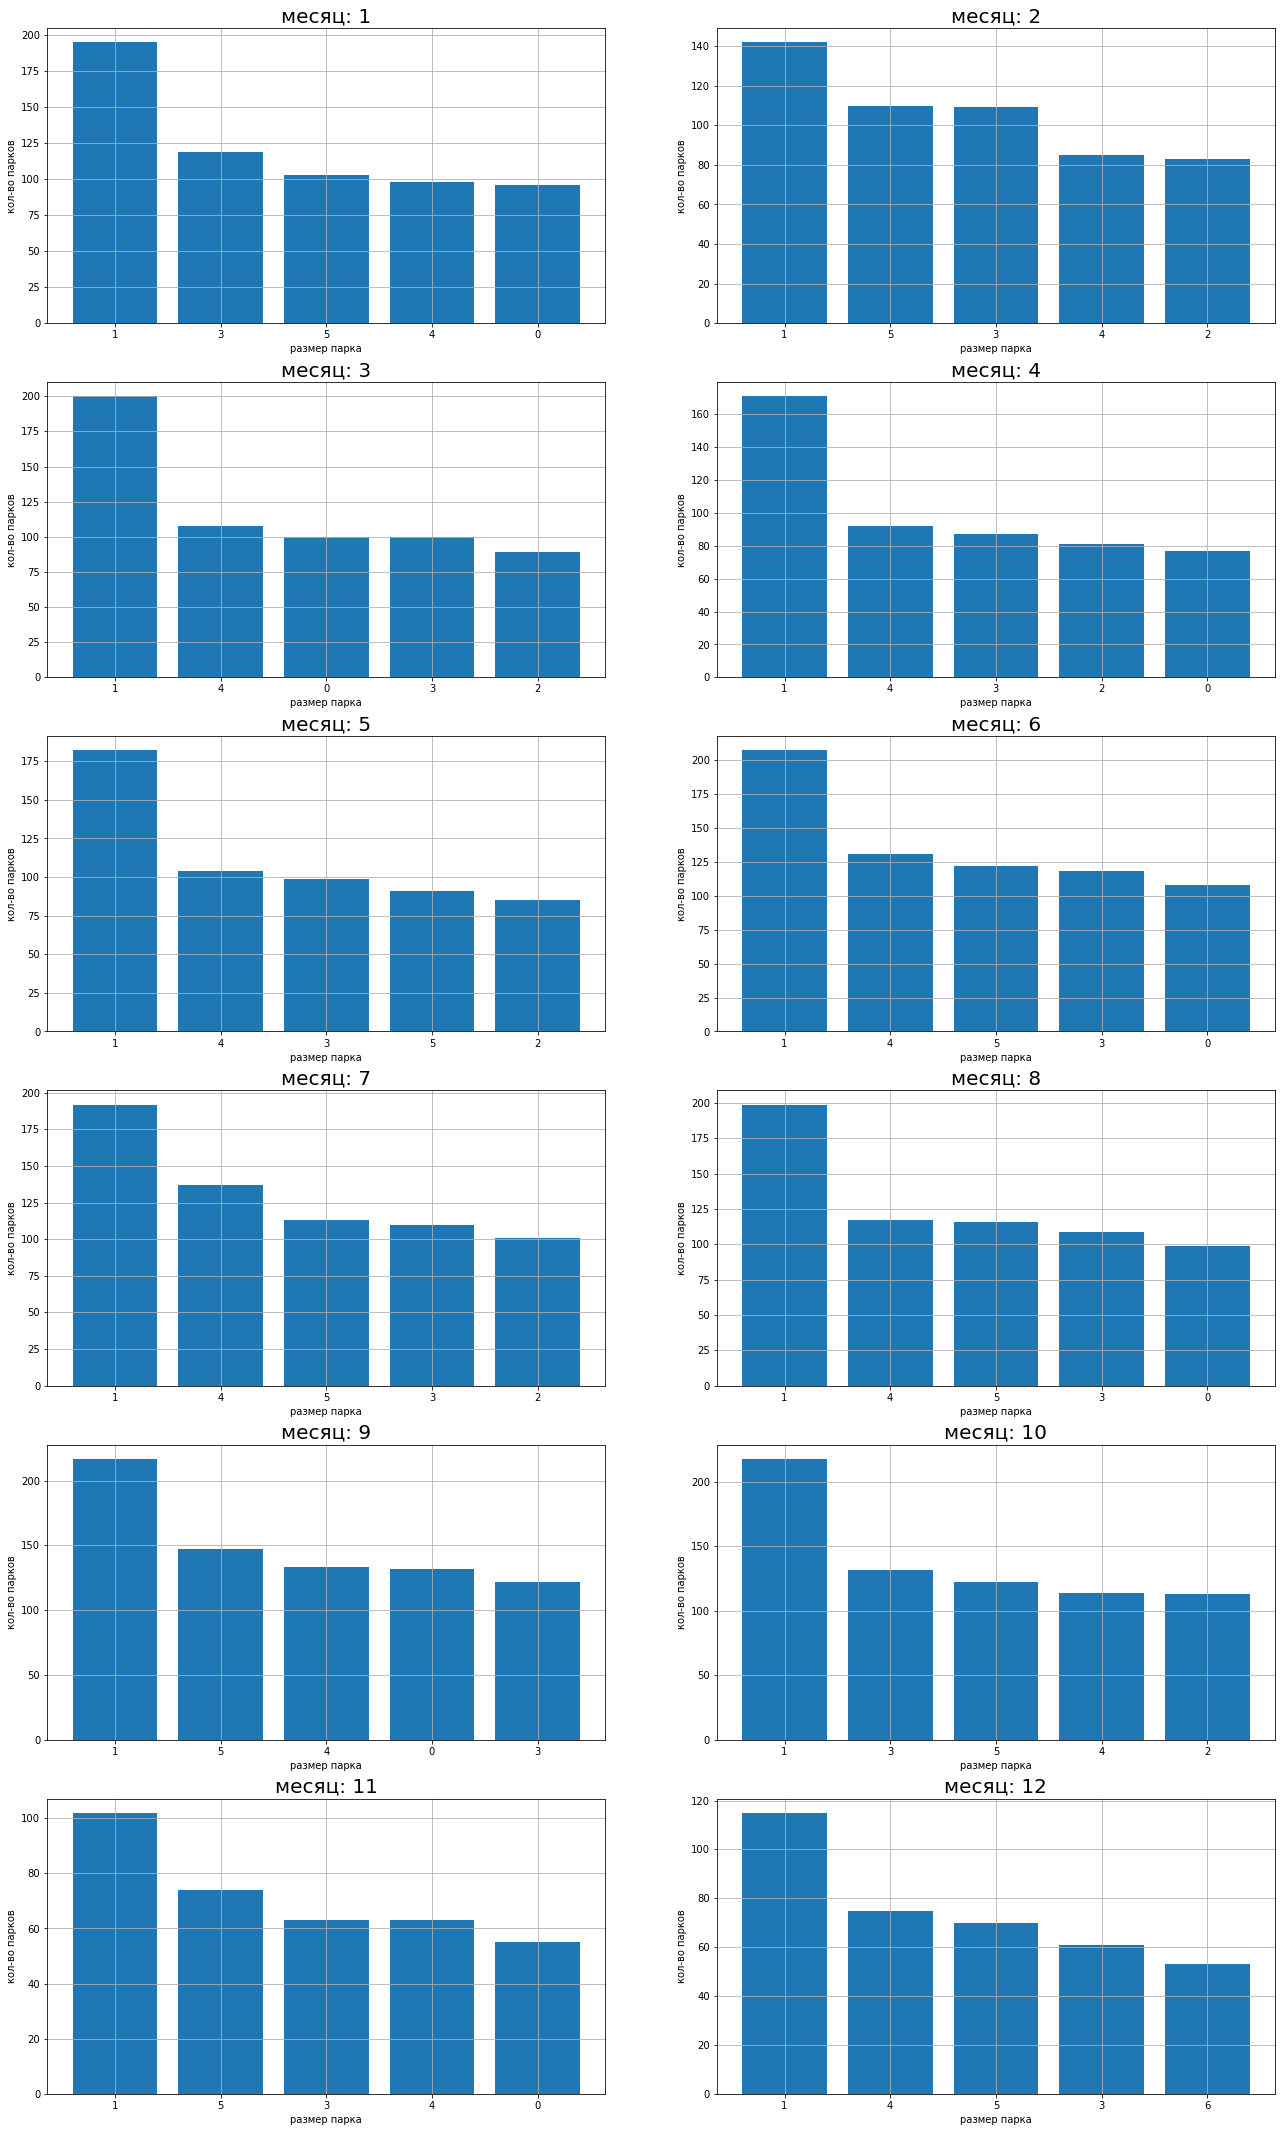

In [12]:
plt.figure(figsize = (22, 38))
for num in range(1,df['Месяц'].max() + 1):
    plt.subplot(6, 2, num)
    plt.bar(question0.loc[question0['Месяц'] == num].head(5)['Размер парка'],
            question0.loc[question0['Месяц'] == num].head(5)['Кол_во_в_мес'])
    
    plt.title(f'месяц: {num}', fontsize=20)
    plt.xlabel('размер парка')
    plt.ylabel('кол-во парков')
    plt.grid()

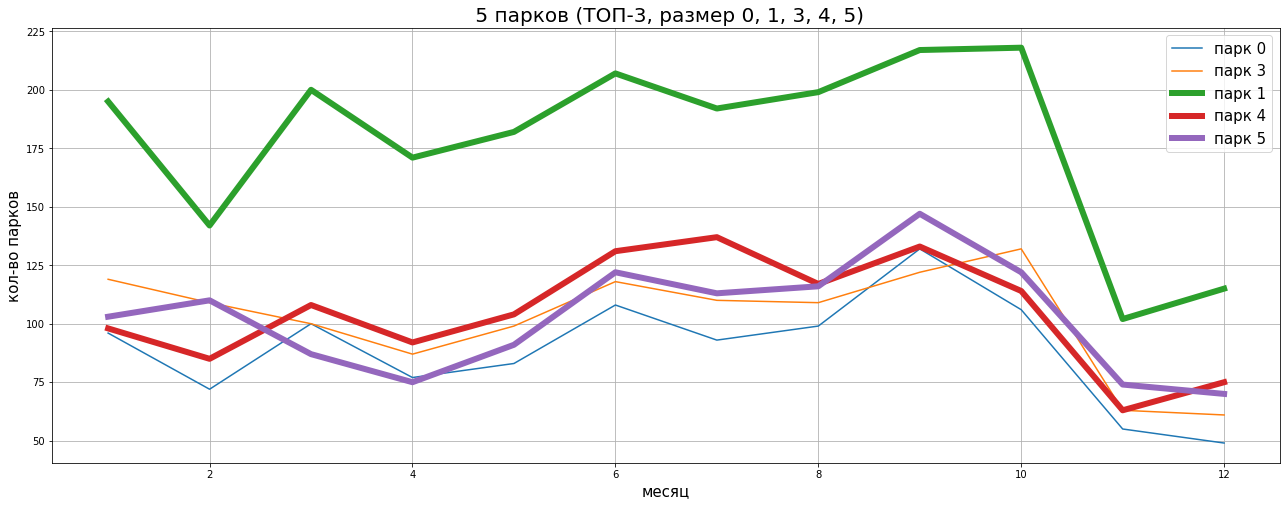

In [13]:
plt.figure(figsize = (22, 8))
for num in [0, 3]:
    plt.plot(question0.loc[question0['Размер парка'] == str(num)].sort_values(by='Месяц')['Месяц'],
            question0.loc[question0['Размер парка'] == str(num)].sort_values(by='Месяц')['Кол_во_в_мес'], label=f'парк {num}')

plt.plot(question0.loc[question0['Размер парка'] == str(1)].sort_values(by='Месяц')['Месяц'],
            question0.loc[question0['Размер парка'] == str(1)].sort_values(by='Месяц')['Кол_во_в_мес'], label=f'парк 1',
        linewidth=6)
plt.plot(question0.loc[question0['Размер парка'] == str(4)].sort_values(by='Месяц')['Месяц'],
            question0.loc[question0['Размер парка'] == str(4)].sort_values(by='Месяц')['Кол_во_в_мес'], label=f'парк 4',
        linewidth=6)
plt.plot(question0.loc[question0['Размер парка'] == str(5)].sort_values(by='Месяц')['Месяц'],
            question0.loc[question0['Размер парка'] == str(5)].sort_values(by='Месяц')['Кол_во_в_мес'], label=f'парк 5',
        linewidth=6)
plt.title(f' 5 парков (ТОП-3, размер 0, 1, 3, 4, 5)', fontsize=20)
plt.xlabel('месяц', fontsize=15)
plt.ylabel('кол-во парков', fontsize=15)
plt.legend(fontsize=15)
plt.grid()

##### Как меняется спрос по месяцам клиентов из одной отрасли?(на всей выборке по месяцам)

In [14]:
mean_clients = question1.groupby('Отрасль', as_index=False).agg({'Кол_во_в_мес': 'sum'})
mean_clients['Кол_во_в_мес'] = round(mean_clients['Кол_во_в_мес'] / 12, 0)

<Figure size 1584x1728 with 0 Axes>

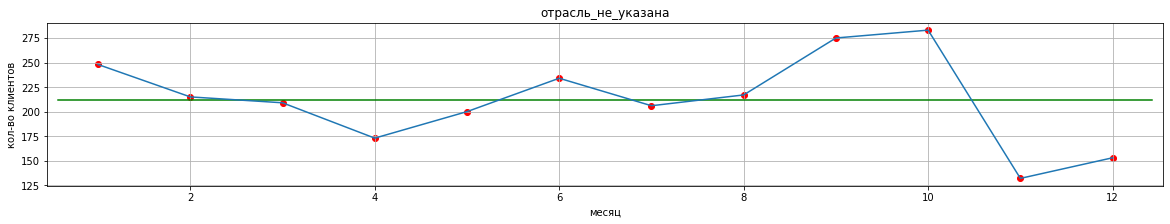

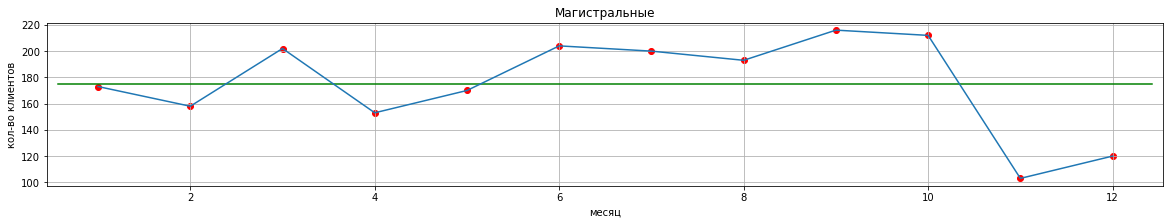

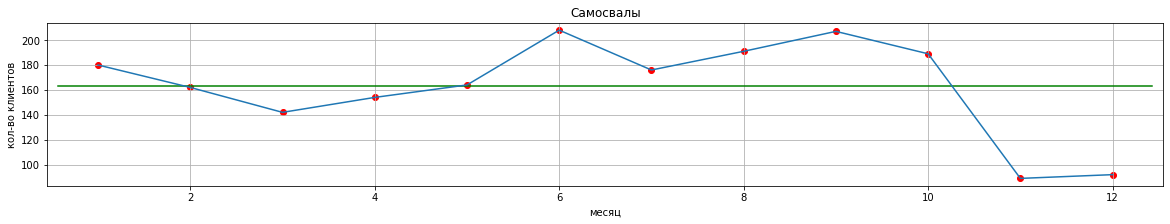

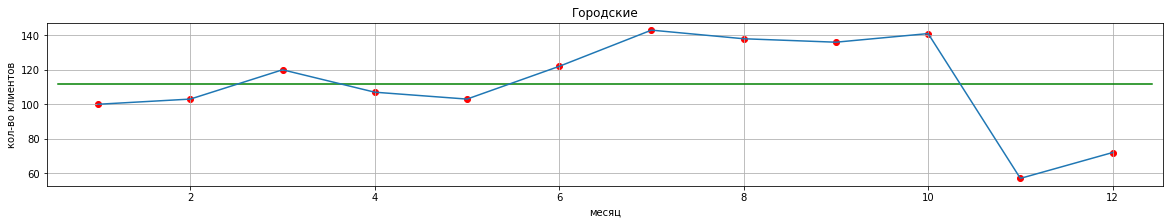

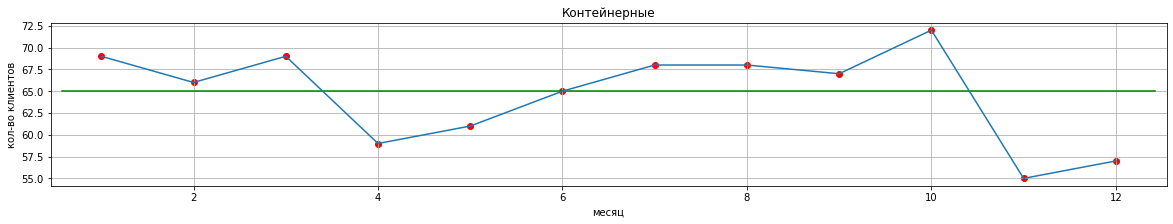

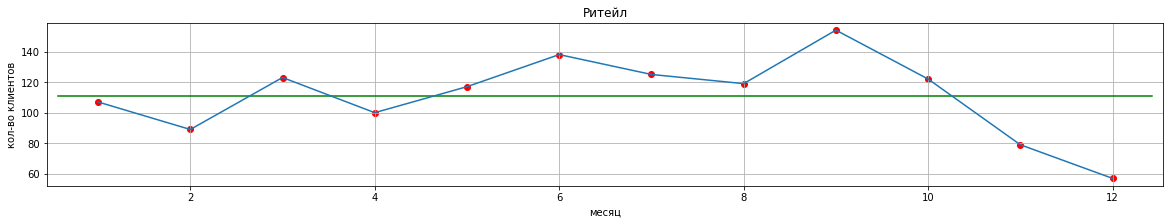

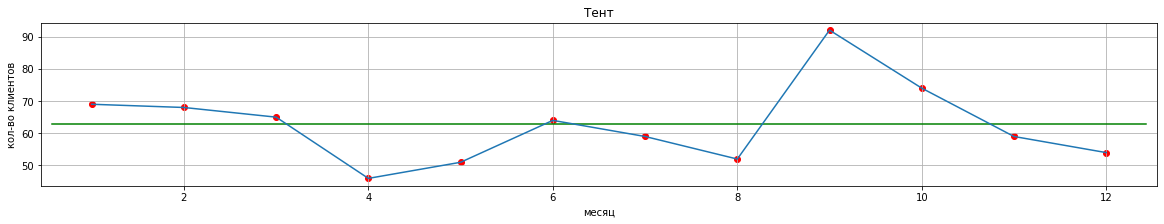

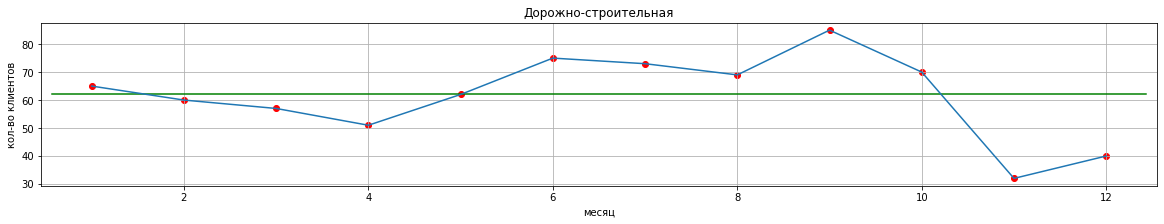

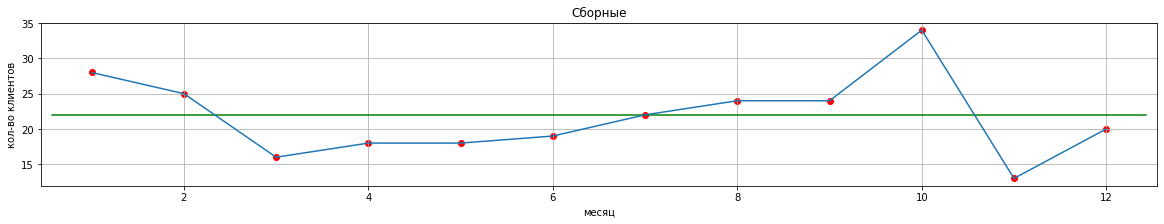

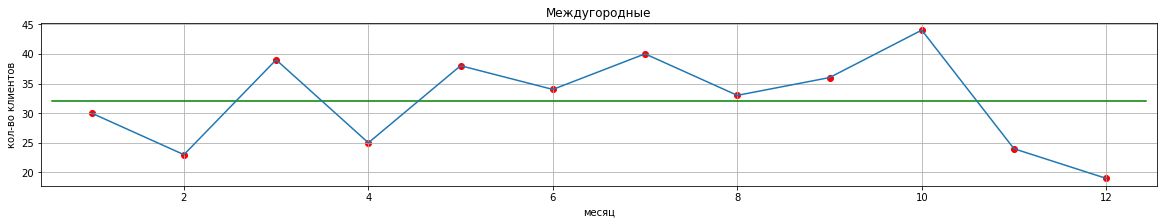

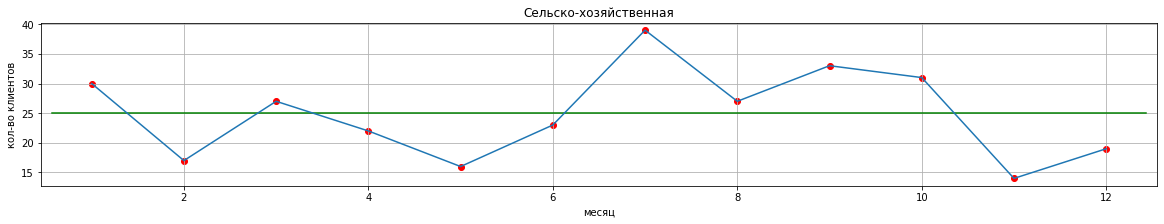

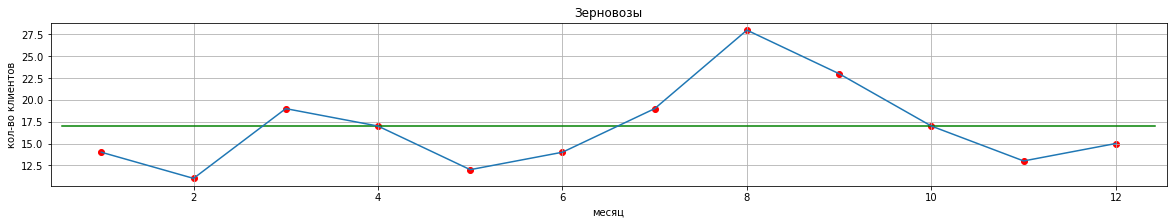

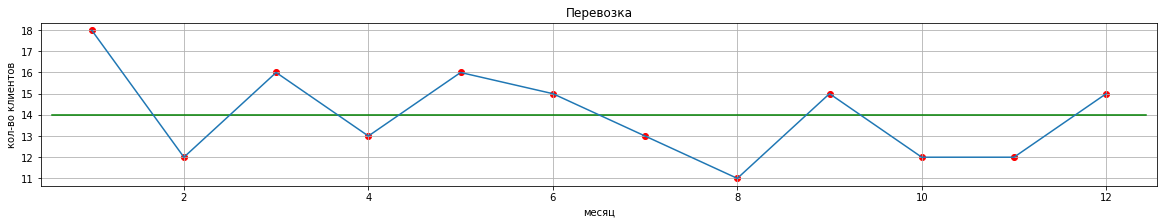

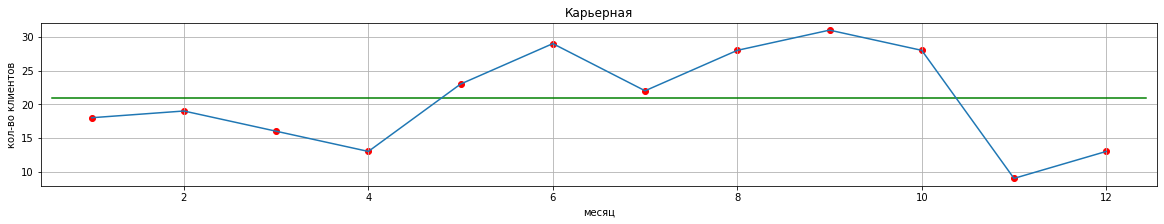

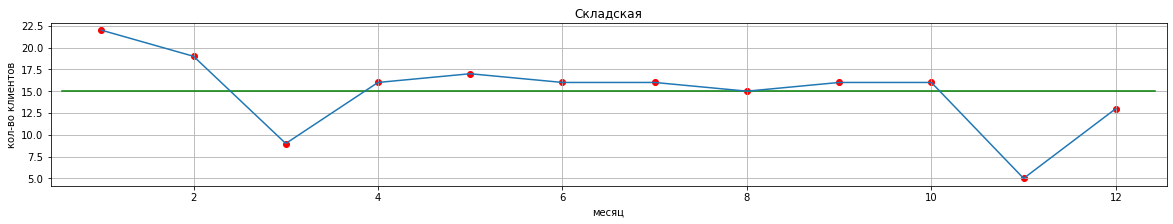

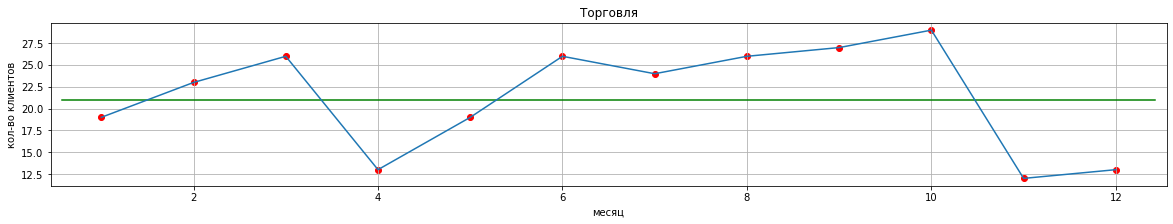

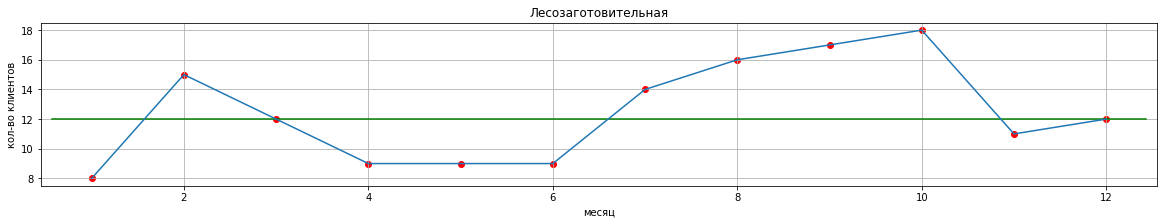

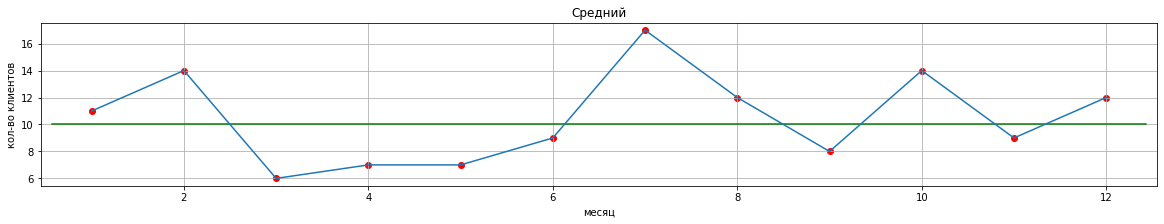

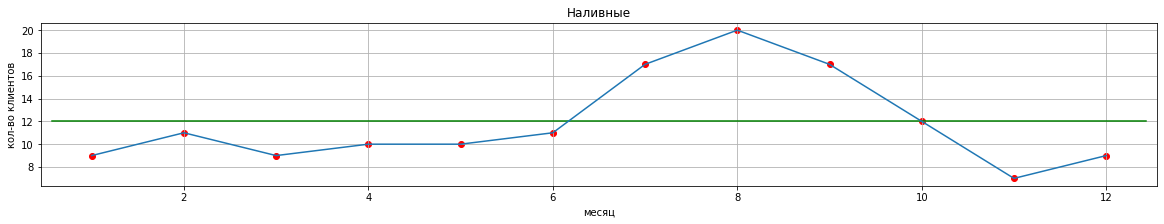

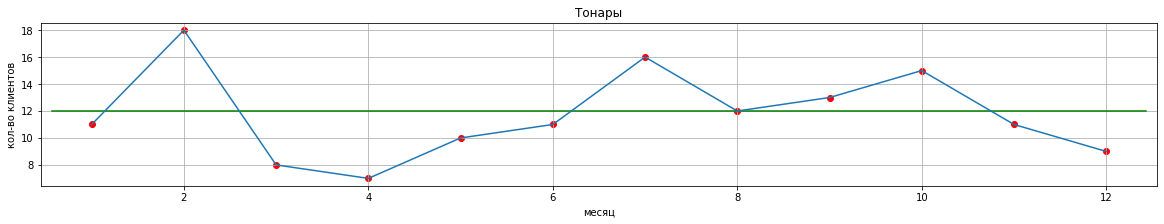

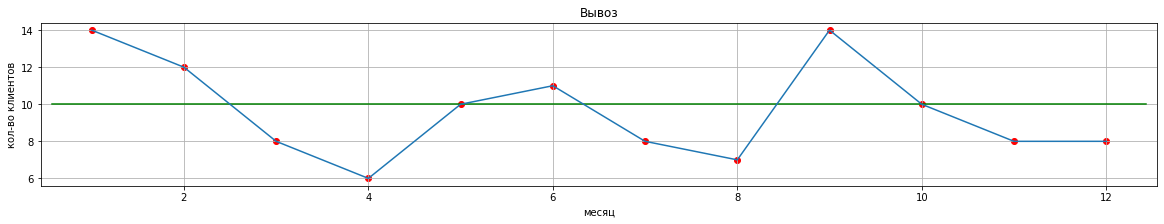

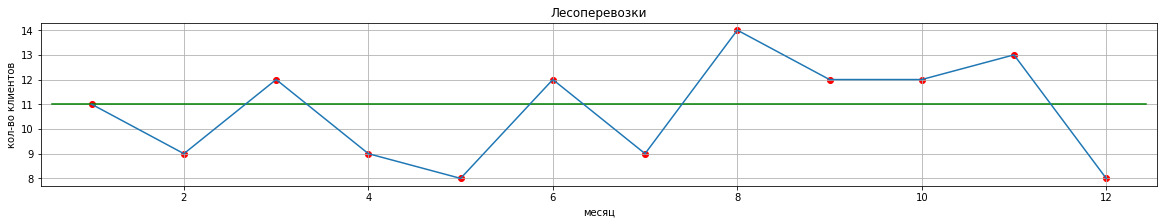

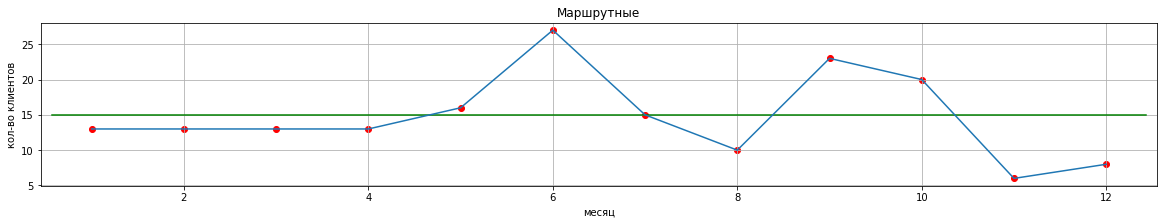

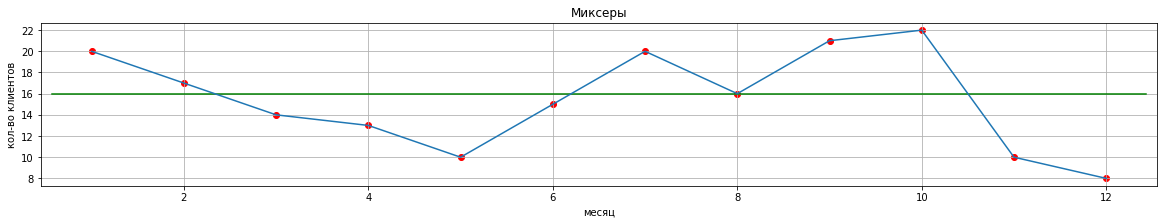

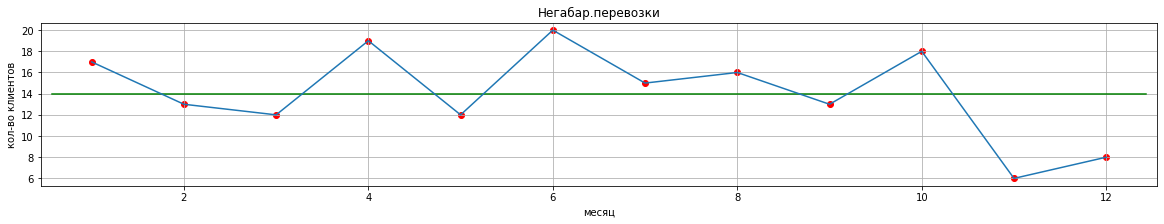

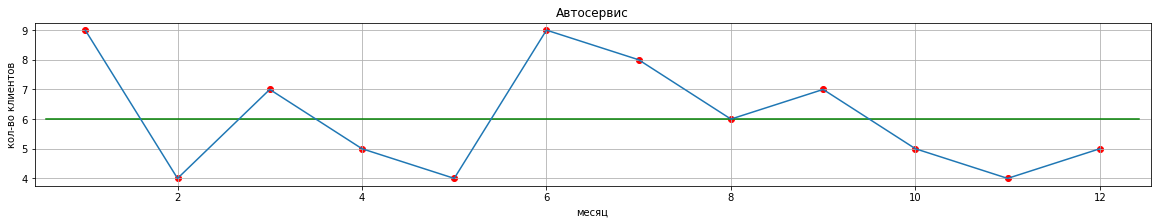

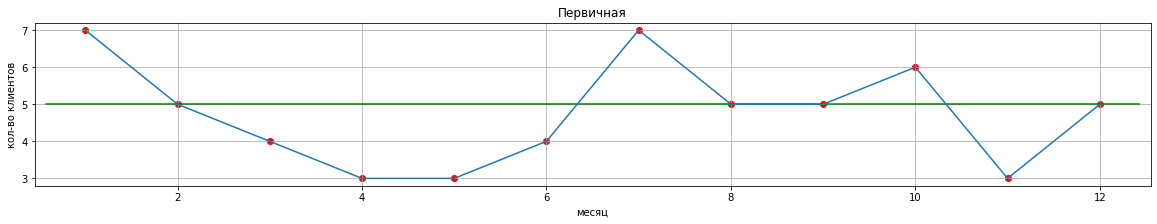

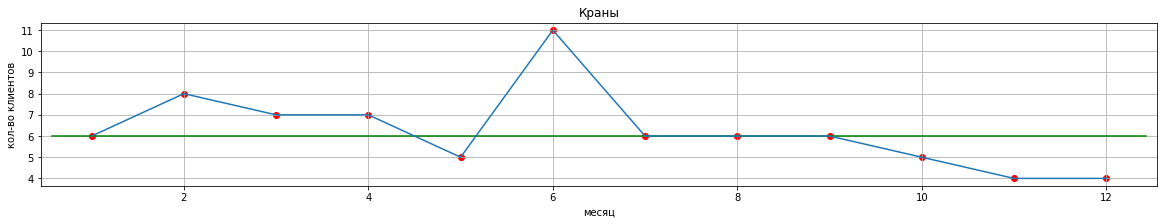

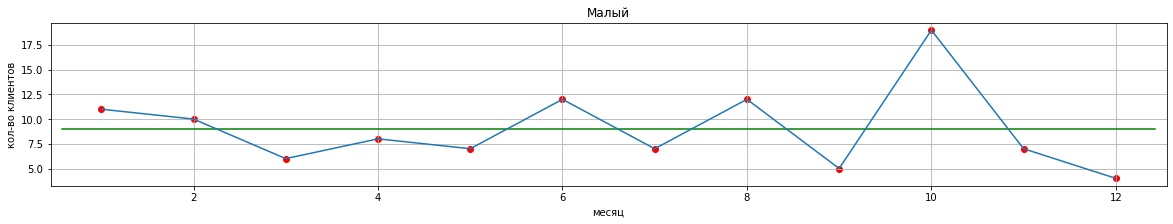

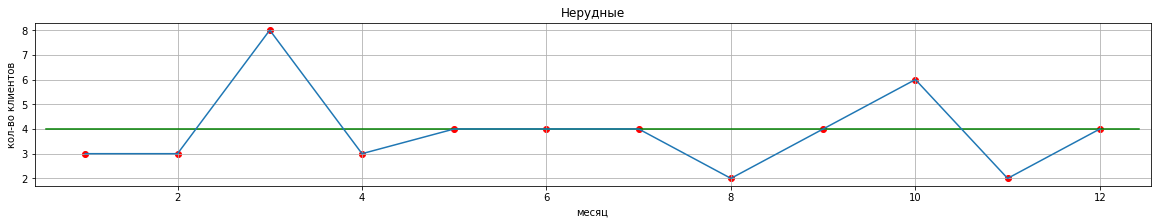

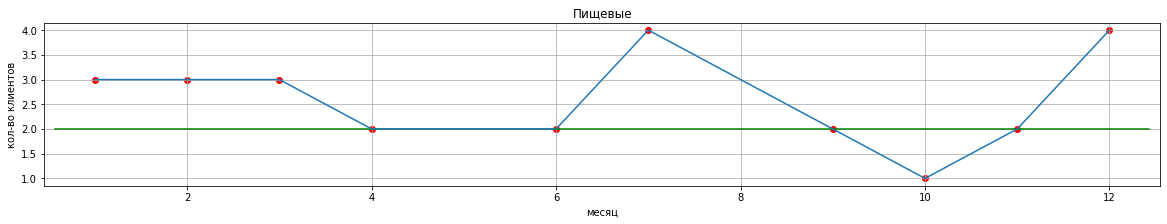

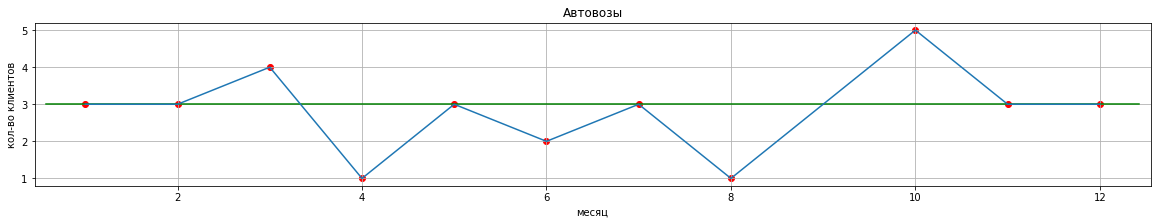

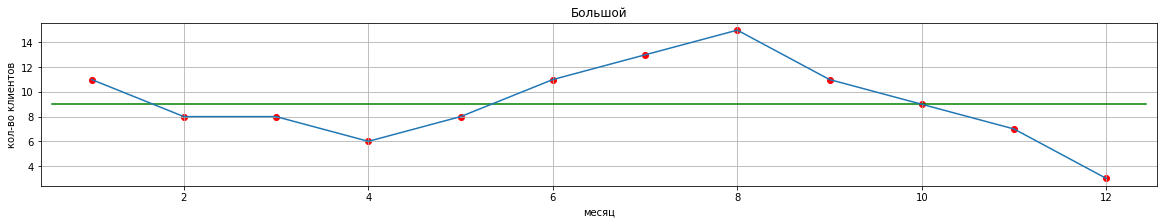

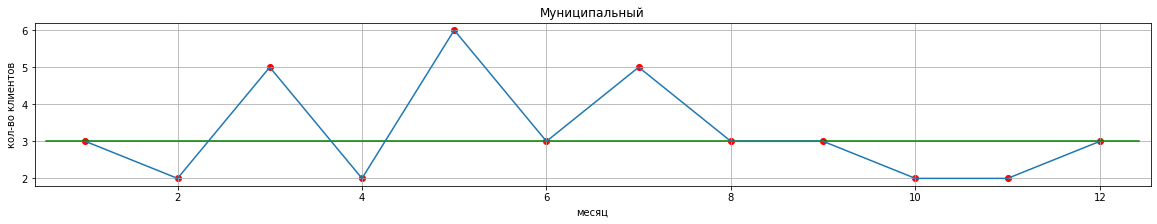

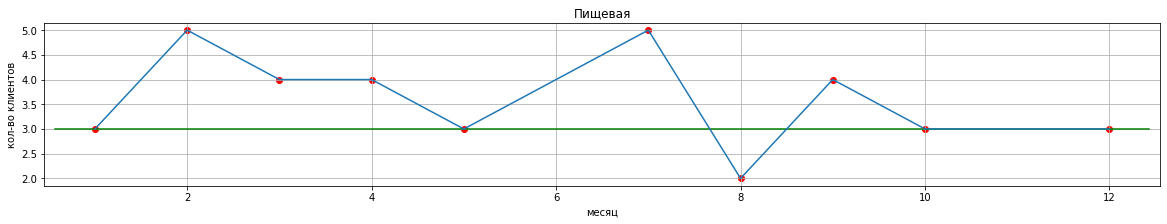

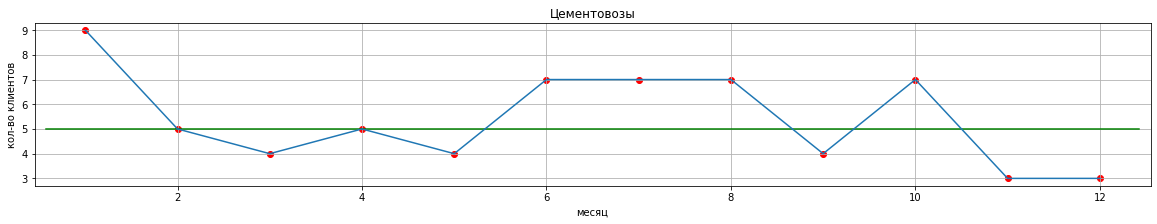

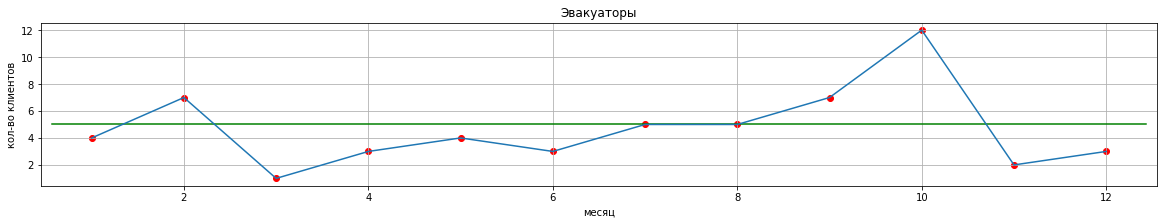

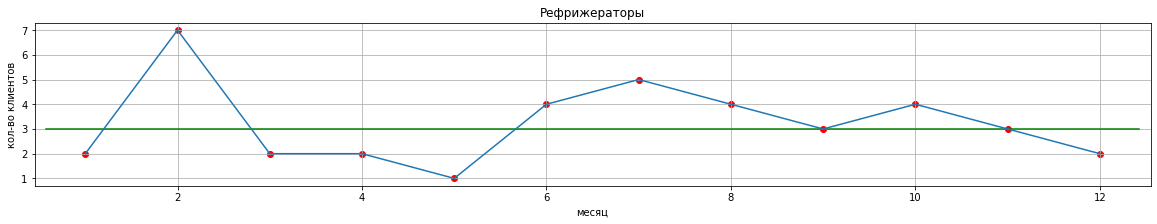

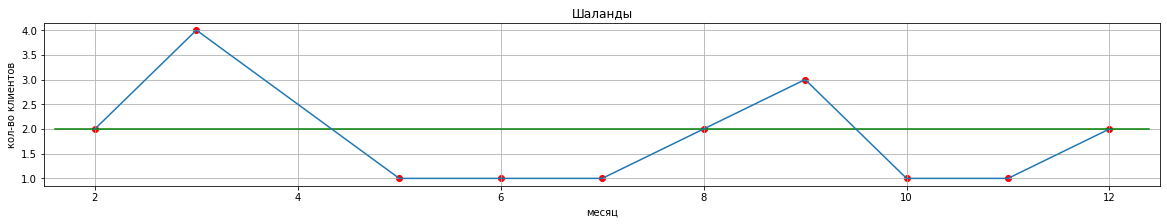

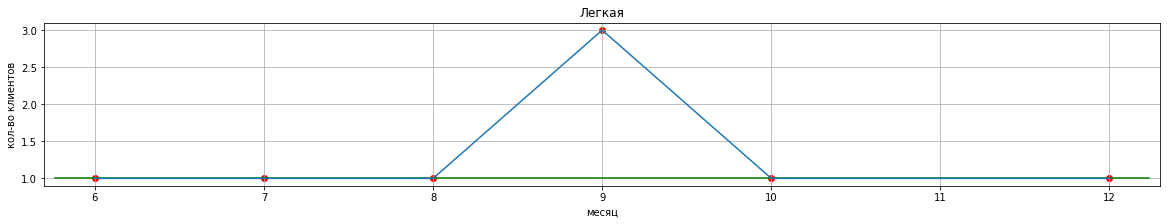

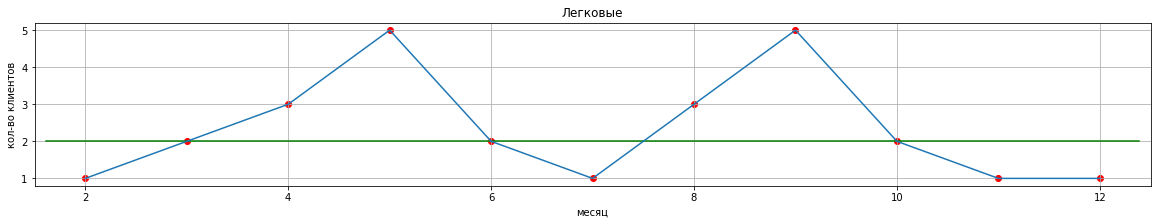

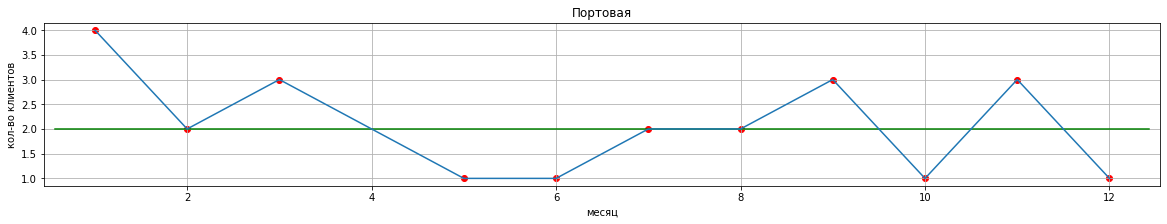

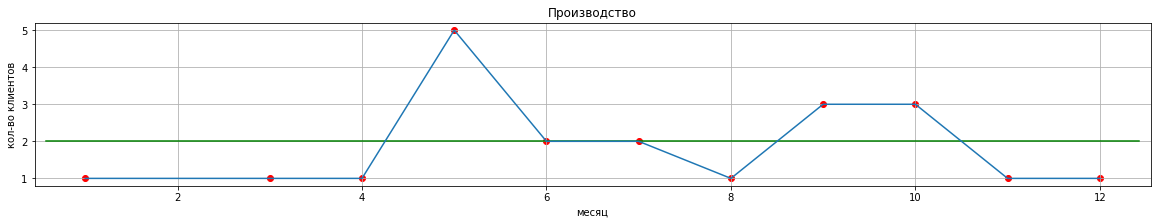

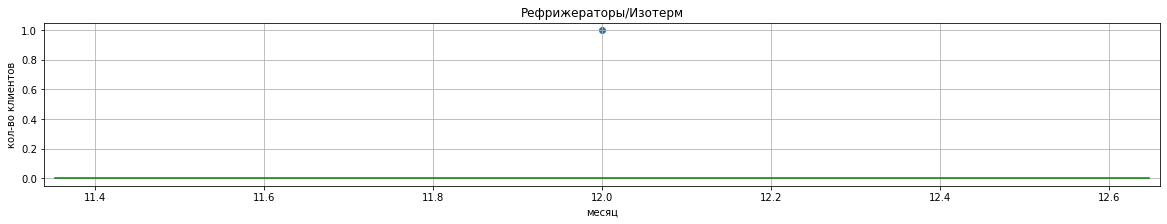

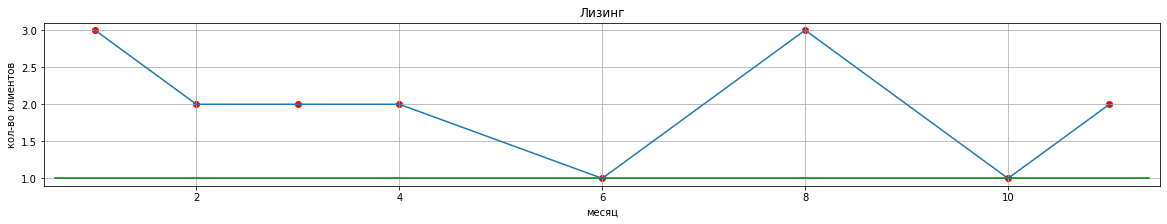

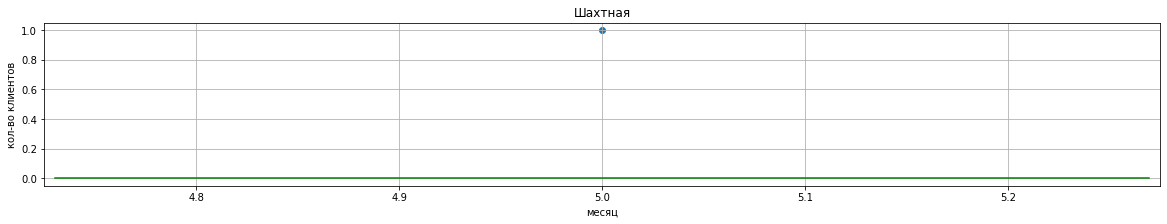

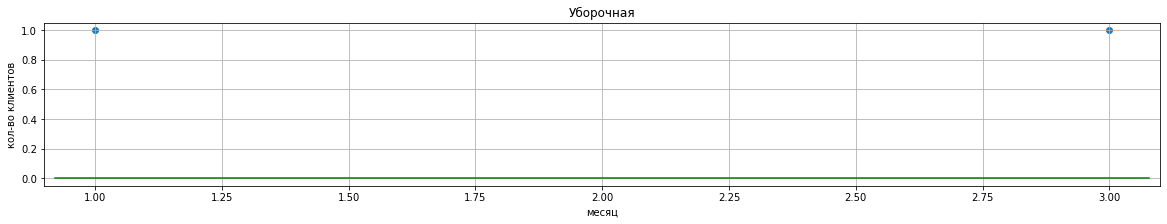

In [15]:
plt.figure(figsize = (22, 24))
for ii in question1['Отрасль'].unique().tolist():
    plt.figure(figsize = (20, 3))
    data = question1.loc[question1['Отрасль'] == ii].sort_values(by='Месяц')
    
    plt.axhline(y=mean_clients.loc[mean_clients['Отрасль'] == ii]['Кол_во_в_мес'].tolist(),
                xmin=0.01, xmax=0.99, color='green')
    
    if len(data['Месяц']) > 2:
        plt.plot(data['Месяц'], data['Кол_во_в_мес'])
        plt.scatter(data['Месяц'], data['Кол_во_в_мес'], color='red')
        
    if len(data['Месяц']) <= 2:
        plt.scatter(data['Месяц'], data['Кол_во_в_мес'])
    plt.title(ii)
    
    plt.xlabel('месяц')
    plt.ylabel('кол-во клиентов')
    plt.grid()
    plt.show()

#### Клиенты из какой сферы больше всего обращаются? (ТОП-7, без учета года, на всей выборке по месяцам)

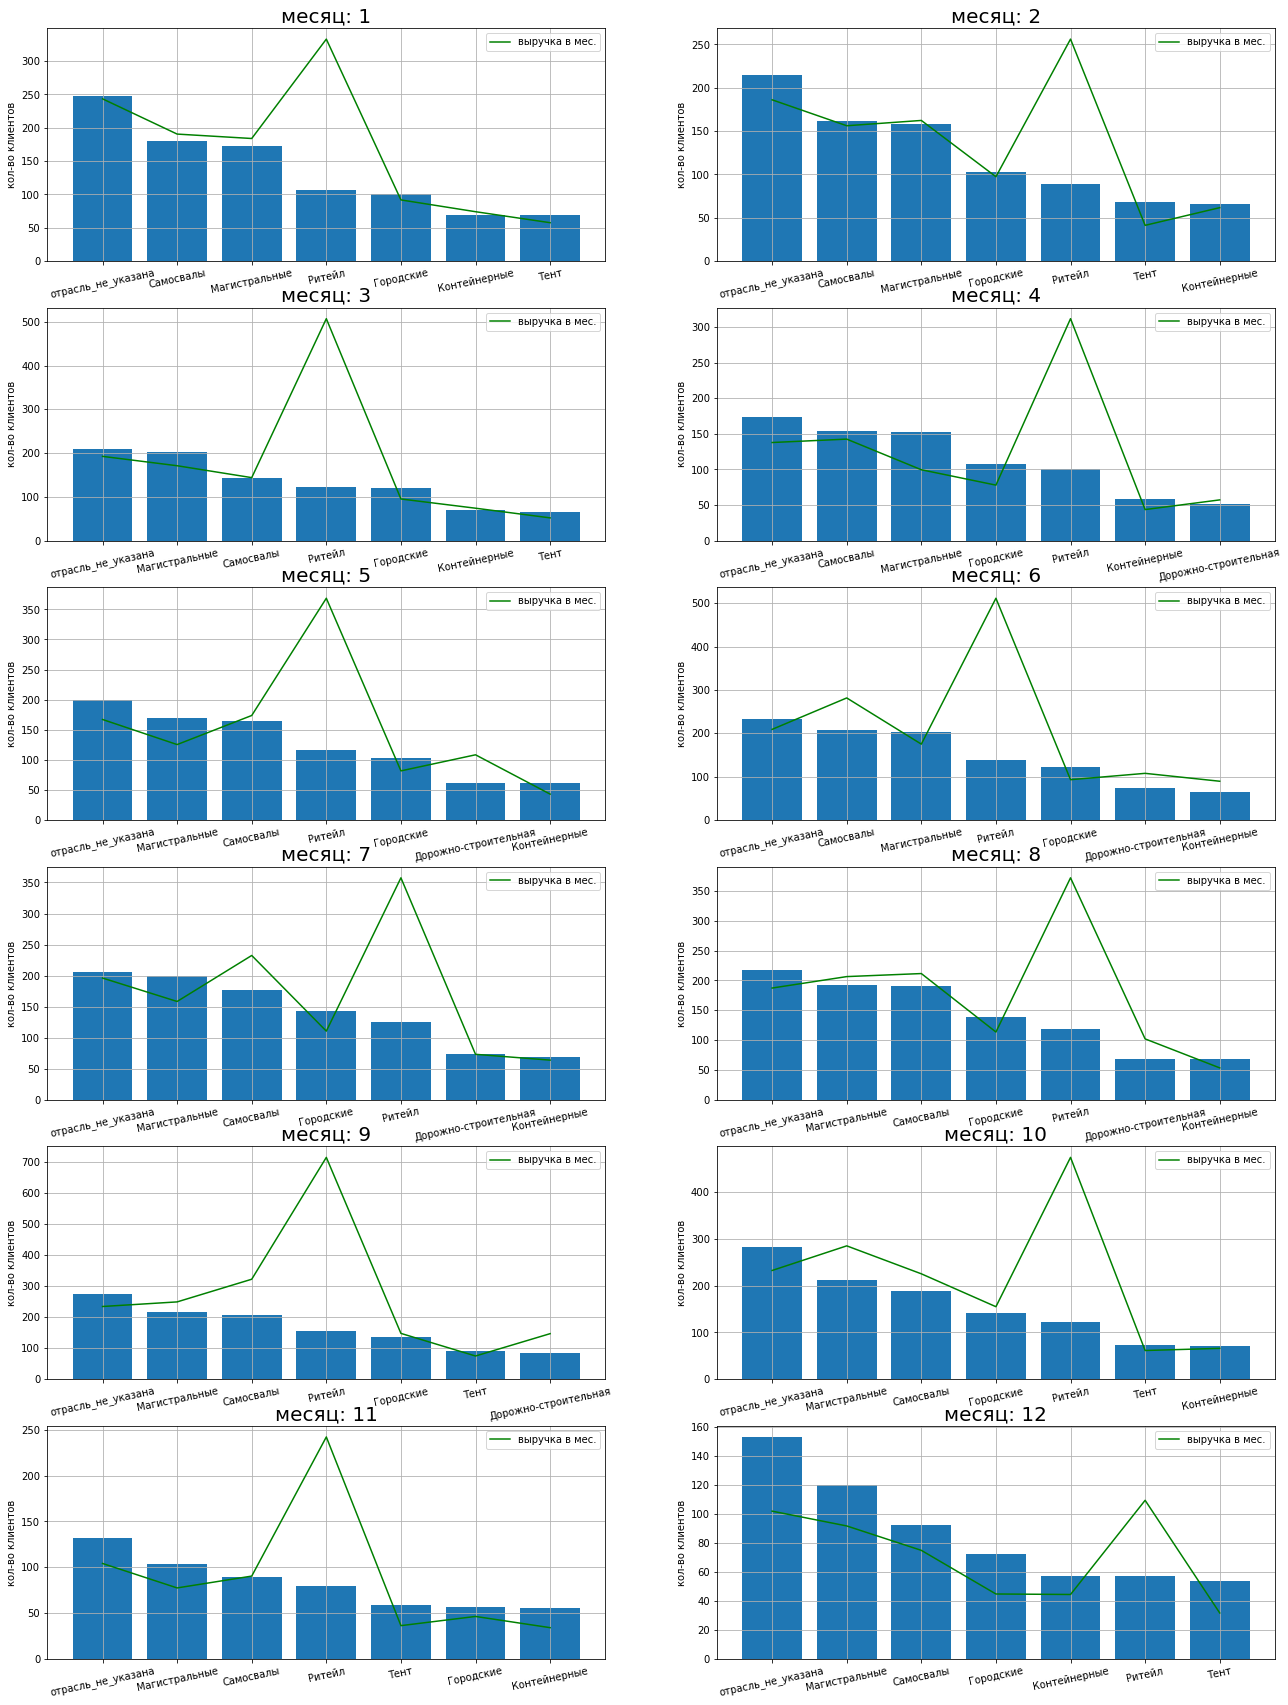

In [16]:
tmp_t = df.groupby(['Месяц','Отрасль'], as_index=False).agg({'Итого': 'sum'})

plt.figure(figsize = (22, 30))
for num in range(1,df['Месяц'].max() + 1):
    plt.subplot(6, 2, num)
    plt.bar(question1.loc[question1['Месяц'] == num].head(7)['Отрасль'],
            question1.loc[question1['Месяц'] == num].head(7)['Кол_во_в_мес'])
    
    local_list = []
    for otrasl in question1.loc[question1['Месяц'] == num].head(7)['Отрасль']:
        local_list.append(tmp_t.loc[(tmp_t['Месяц'] == num) & (tmp_t['Отрасль'] == otrasl) ]['Итого'].tolist()[0])
    

    plt.plot(range(len(question1.loc[question1['Месяц'] == num].head(7))), np.array(local_list) / 10,
             label='выручка в мес.', color='green')
    
    plt.title(f'месяц: {num}',fontsize=20)
    plt.xticks(rotation=12)
    plt.legend()
    plt.ylabel('кол-во клиентов')
    plt.grid()

#### 1.1. Вывод по задаче 1  <a class='anchor' id='end_task1'>

- По всем месяцам превалируют парки размером '1';
- На втором месте чаще всего парки размером '4' (3, 4, 5, 6, 7, 8 и 12 месяцы), также на втором месте в 2, 9 и 11 месяцах превалируют парки размером '5' и еще реже встречаются парки размером '3' (1 и 10 месяцы);
- На третьем месте половину года превалируют парки размером '5'(1, 6, 7, 8, 10, 12 месяцы), чуть реже парки размером '3' (2, 4, 5, 11), а также нулевые парки(возможно парки размером '0' это частные лица) в 3-ем месяце и '5' в 12 месяце.

---------------------
- По количеству клиентов по всем месяцам превалирует отрасль без названия ("отрасль_не_указана"), второе и третье место с переменным успехом делят отрасли "Магистральные" и "Самосвалы". Также необходимо отметить, что наибольшую выручку в каждом из месяцев приносит отрасль "Ритейл", которая входит в ТОП-6 отраслей по количеству клиентов в месячном разрезе.

-----------------

### 2. Парки разбить на сегменты по размеру парка 0-3, 4-20, 20-50, 50+ <a class='anchor' id='task2'>

In [17]:
df['Сегмент'] = 0
df.loc[(df['Размер парка'] >= 0) & (df['Размер парка'] <=3), 'Сегмент'] = '0-3'
df.loc[(df['Размер парка'] >= 4) & (df['Размер парка'] <=20), 'Сегмент'] = '4-20'
df.loc[(df['Размер парка'] >= 21) & (df['Размер парка'] <=50), 'Сегмент'] = '21-50'
df.loc[df['Размер парка'] >= 51, 'Сегмент'] = '51+'

In [18]:
question2 = df.groupby('Сегмент', as_index=False).agg({'Код клиента': 'count'}).rename(
    columns={'Код клиента': 'Кол_во_в_сегменте'}).sort_values(by='Кол_во_в_сегменте', ascending=False)
question2

Сегмент  Кол_во_в_сегменте
2    4-20               8178
0     0-3               5456
1   21-50               1427
3     51+                696

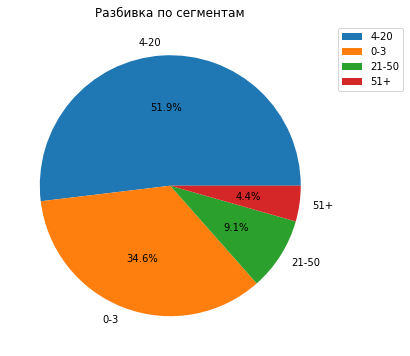

In [19]:
plt.figure(figsize = (10, 6))
plt.pie(question2['Кол_во_в_сегменте'],
        labels=question2['Сегмент'],
        autopct='%1.1f%%')
plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
plt.title('Разбивка по сегментам')
plt.show()

In [20]:
tmp_t2 = df.groupby('Сегмент', as_index=False).agg({'Итого': 'sum'})
tmp_t2

Сегмент    Итого
0     0-3  75235.2
1   21-50  22652.5
2    4-20  75080.5
3     51+  20056.6

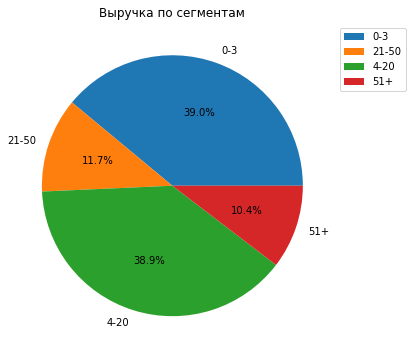

In [21]:
plt.figure(figsize = (10, 6))
plt.pie(tmp_t2['Итого'],
        labels=tmp_t2['Сегмент'],
        autopct='%1.1f%%')
plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
plt.title('Выручка по сегментам')
plt.show()

In [22]:
list_to_replace = {'0-3': 1, '4-20':2, '21-50':3, '51+':4}
df['Номер_сегмента'] = df['Сегмент']
df['Номер_сегмента'] = df['Номер_сегмента'].map(list_to_replace)

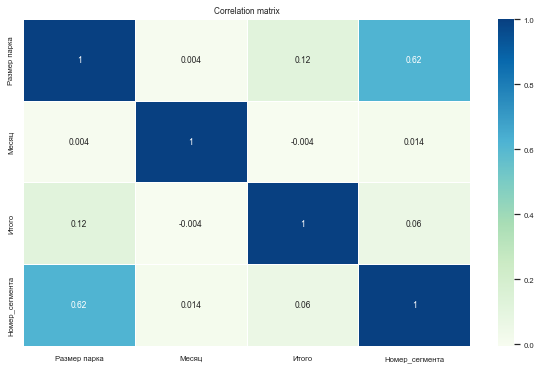

In [67]:
plt.figure(figsize = (10,6))
sns.set(font_scale=0.7)
sns.heatmap( df.corr().round(3), annot=True, linewidths=.5, 
            cmap='GnBu'
           )
plt.title('Correlation matrix')
plt.show()

#### 2.1. Вывод по задаче 2  <a class='anchor' id='end_task2'>

- В предложенной сегментации по размеру парка наибольшее количество занимает сегмент '4-20', за ним следует сегмент '0-3'. При общей доле сегмента '4-20' в 52% доля выручки составляет 39%, а при общей доле сегмента '0-3' в 35% доля выручки составляет также 39%. Тоже самое характерно для сегментов '21-50' и '51+', где сегмент '51+' при меньшей доле дает большую выручку.


- Предложенная сегментация достаточно хороша, что показывает коэффициент коррелиции 0.62 - средняя корреляция между размером парка и сегментами (средняя - диапазон от 0.3 до 0.7, оптимальный случай: низкая(<0.3) корреляция при широкой сегментации).

-----------------

### 3. Предложить порядок действий по отраслям в разрезе кварталов <a class='anchor' id='task3'>

In [24]:
list_to_replace = {1:'1', 2:'1', 3:'1',
                   4:'2', 5:'2', 6:'2',
                   7:'3', 8:'3', 9:'3',
                   10:'4', 11:'4', 12:'4'};
df['Квартал'] = df['Месяц']
df['Квартал'] = df['Квартал'].map(list_to_replace)
df.head(2)

Код клиента  Размер парка  Месяц   Итого    Отрасль Сегмент  \
0  00-00049327             4      2  1020.0   Торговля    4-20   
1  00-00005692            24      9   642.6  Самосвалы   21-50   

   Номер_сегмента Квартал  
0               2       1  
1               3       3

In [25]:
tmp_t2r = df.groupby('Отрасль', as_index=False).agg({'Итого': 'count'}).sort_values(by='Итого', )
tmp_t2r.head(2)

Отрасль  Итого
44                Шахтная      1
31  Рефрижераторы/Изотерм      1

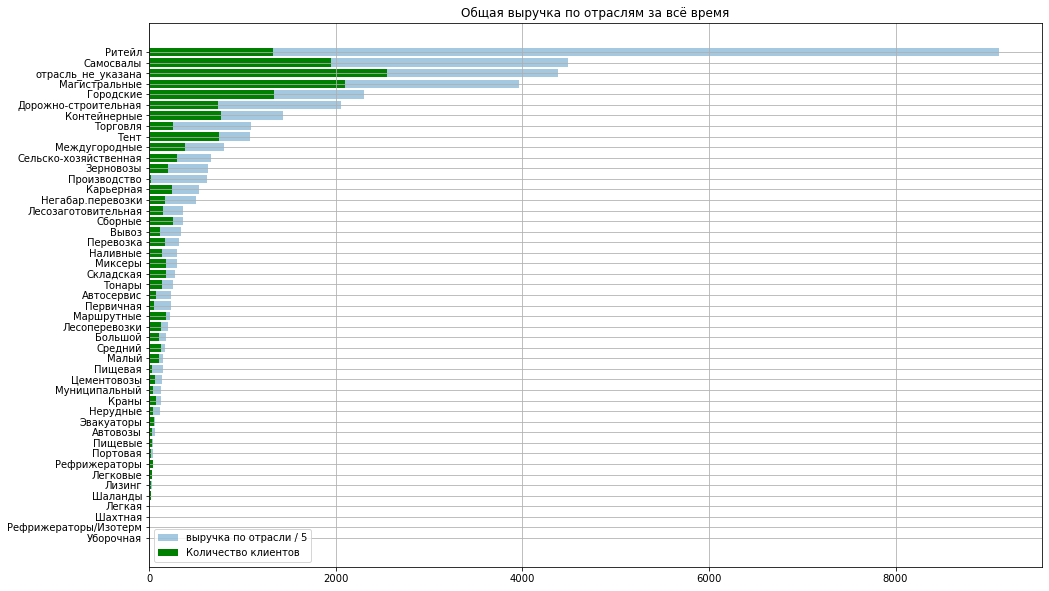

In [26]:
local_dict = {}
tmp_t = df.groupby('Отрасль', as_index=False).agg({'Итого': 'count'}).sort_values(by='Итого',)
tmp_t2 = df.groupby('Отрасль', as_index=False).agg({'Итого': 'sum'}).sort_values(by='Итого', )

plt.figure(figsize = (16, 10))
plt.barh(tmp_t2['Отрасль'], np.array(tmp_t2['Итого']) / 5, label='выручка по отрасли / 5', alpha=0.4)
plt.barh(tmp_t['Отрасль'], tmp_t['Итого'], label='Количество клиентов', color='green')
plt.title('Общая выручка по отраслям за всё время')
plt.legend()
plt.grid()

In [27]:
def prepare_data(field:str, quarter:str):

    tmp4 = df.loc[(df['Отрасль'] == field) & (df['Квартал'] == quarter)]
    tmp4 = tmp4.groupby(['Сегмент','Номер_сегмента'], as_index=False).agg({'Итого': 'sum'}).sort_values(by='Номер_сегмента')

    if len(tmp4.loc[tmp4['Сегмент'] == '0-3']['Итого']) > 0:
        one = tmp4.loc[tmp4['Сегмент'] == '0-3']['Итого']
    else:
        one = 0

    if len(tmp4.loc[tmp4['Сегмент'] == '4-20']['Итого']) > 0:
        two = tmp4.loc[tmp4['Сегмент'] == '4-20']['Итого']
    else:
        two = 0

    if len(tmp4.loc[tmp4['Сегмент'] == '21-50']['Итого']) > 0:
        three = tmp4.loc[tmp4['Сегмент'] == '21-50']['Итого']
    else:
        three = 0

    if len(tmp4.loc[tmp4['Сегмент'] == '51+']['Итого']) > 0:
        four = tmp4.loc[tmp4['Сегмент'] == '51+']['Итого']
    else:
        four = 0

    return {'0-3':one,'4-20':two,'21-50':three,'51+':four}


def draw_plot_top_sales(field:str):
    for ii in range(1,5):
        ff = prepare_data(field, str(ii))

        plt.plot(ff.keys(), ff.values(), label=f'{ii} квартал')
    plt.ylabel('выручка')
    plt.legend()
    plt.title(field)
    plt.grid()

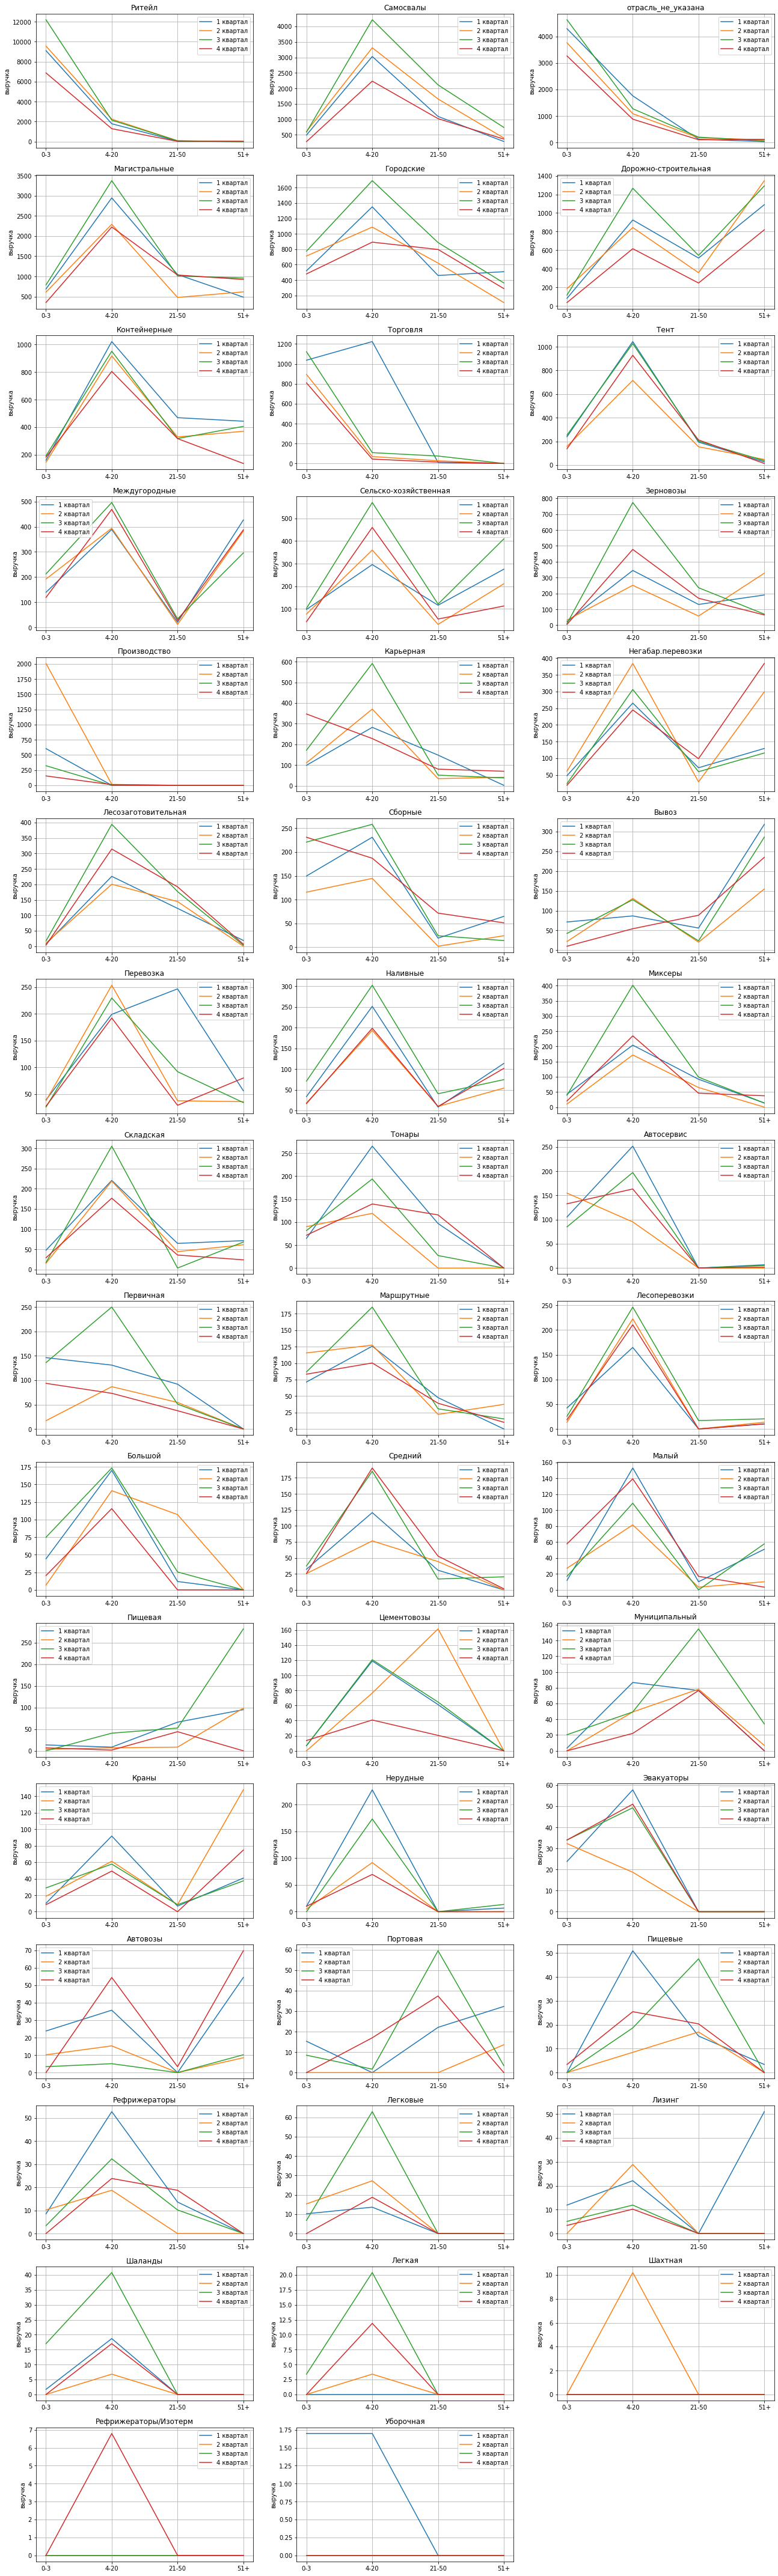

In [28]:
tmp0 = df.groupby('Отрасль', as_index=False).agg({'Итого': 'sum'}).sort_values(by='Итого', ascending=False)

plt.figure(figsize = (22, 78))
for num, name in enumerate(tmp0['Отрасль'], start=1):
    plt.subplot(16, 3, num)
    draw_plot_top_sales(name)

In [65]:
def draw_plot(field:str, segment:str):
    num_clients = []
    profit = []
    for ii in range(1, 5):
        num_clients.append(len(
            df.loc[(df['Отрасль'] == field) & (df['Квартал'] == str(ii)) & (df['Сегмент'] == segment)]))

        profit.append(df.loc[
            (df['Отрасль'] == field) & (df['Квартал'] == str(ii)) & (df['Сегмент'] == segment)]['Итого'].sum() / 10)

    plt.title(f"{field} {segment}")
    plt.plot(range(1, len(num_clients)+1), num_clients, label='num_clients')
    plt.plot(range(1, len(profit)+1), profit, label='sum_profit / 10', color='green')
    plt.scatter(range(1, len(num_clients)+1), num_clients, )
    plt.scatter(range(1, len(profit)+1), profit, )
#     plt.grid()
    plt.legend()
    plt.xlabel('квартал')
    plt.grid()
#     np.log(

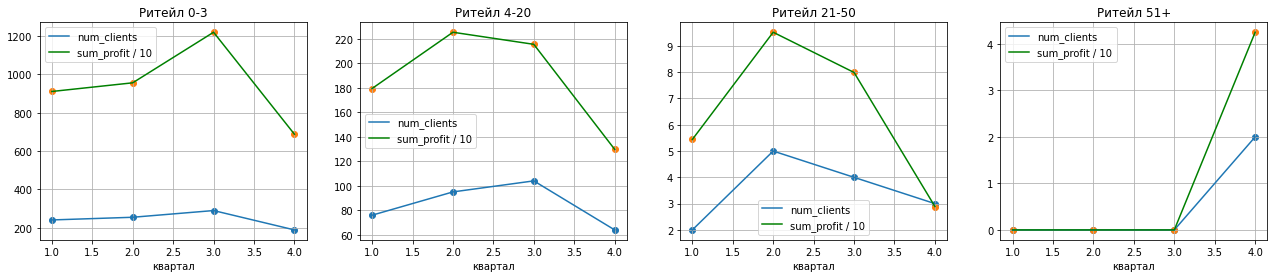

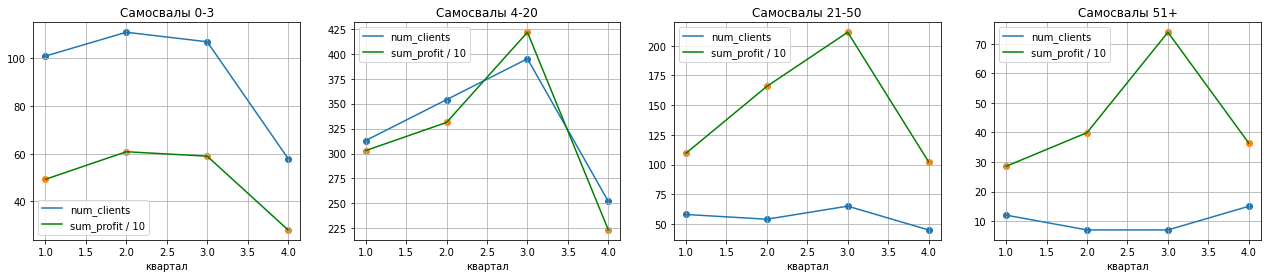

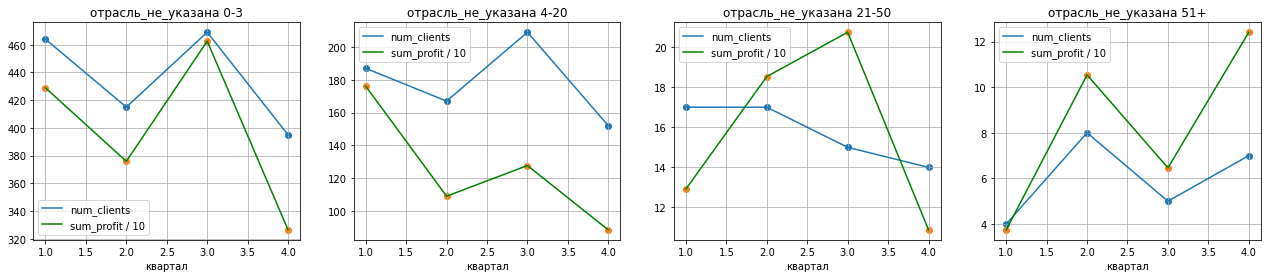

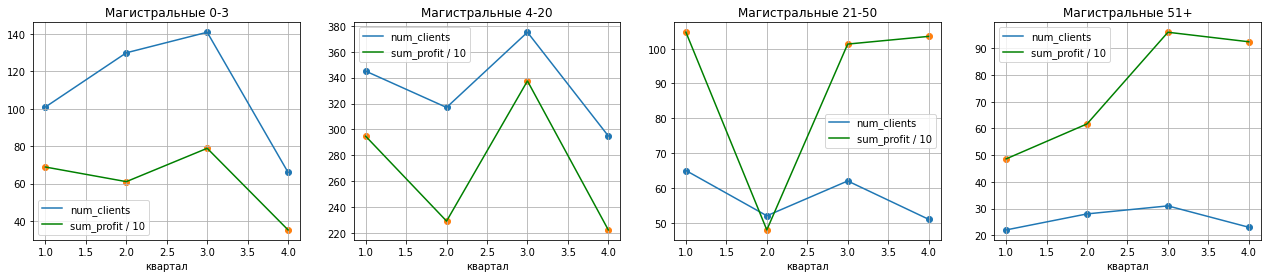

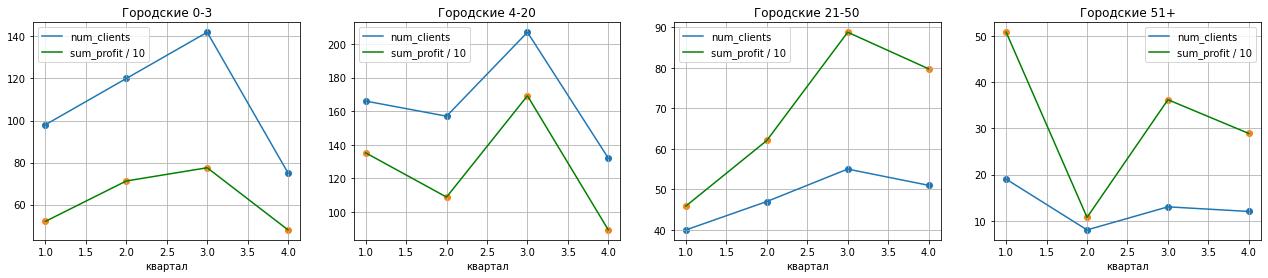

In [66]:
# ТОП 5 отраслей
for num, name in enumerate(tmp0['Отрасль'][:5], start=1):
    plt.figure(figsize = (22, 4))
    plt.subplot(1, 4, 1)
    draw_plot(name, '0-3')

    plt.subplot(1, 4, 2)
    draw_plot(name, '4-20')

    plt.subplot(1, 4, 3)
    draw_plot(name, '21-50')

    plt.subplot(1, 4, 4)
    draw_plot(name, '51+')
    
    plt.show()

In [31]:
def draw_plot_double(field:str, segment:str, ):
    tt = pd.merge(df.loc[(
        df['Отрасль'] == field) & (df['Сегмент'] == segment)].groupby('Месяц', as_index=False).agg({'Итого': 'sum'}),
             pd.DataFrame(df.loc[
             (df['Отрасль'] == field) & 
             (df['Сегмент'] == segment)]['Месяц'].value_counts()).reset_index().rename(
                 columns={'Месяц': 'кол-во', 'index': 'Месяц'}),
             how='left', on='Месяц'
    )
    plt.scatter(tt['кол-во'], tt['Итого'])
    plt.ylabel('выручка')
    plt.xlabel('кол-во клиентов по месяцам')
    plt.title(f'{field} {segment}')
    
    plt.plot([0, 0], [0, 0], 'red')
 
    plt.grid()

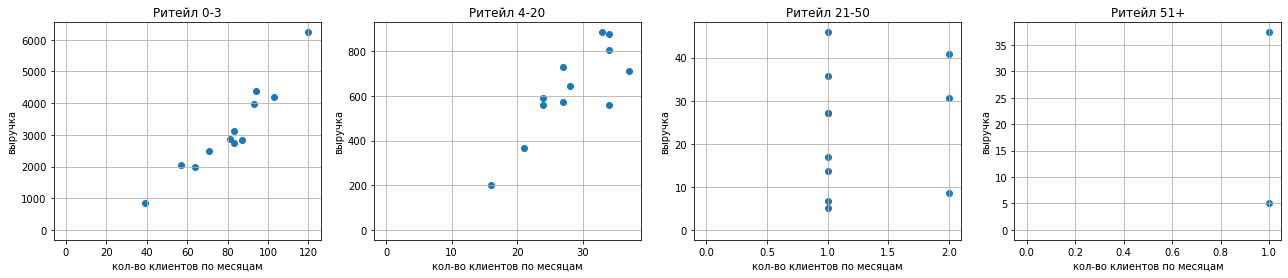

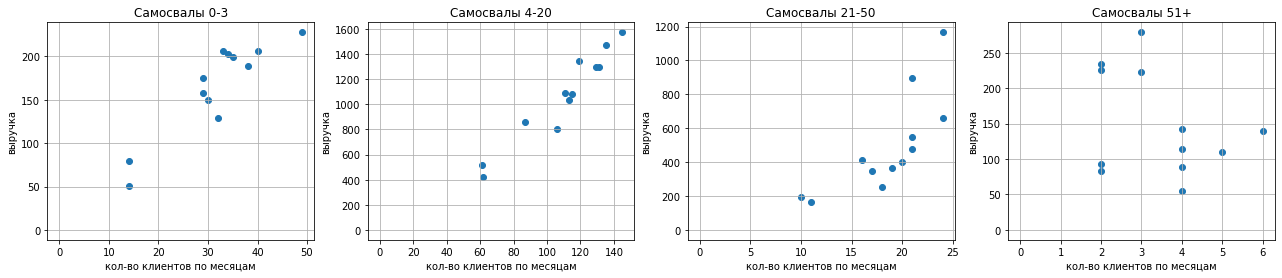

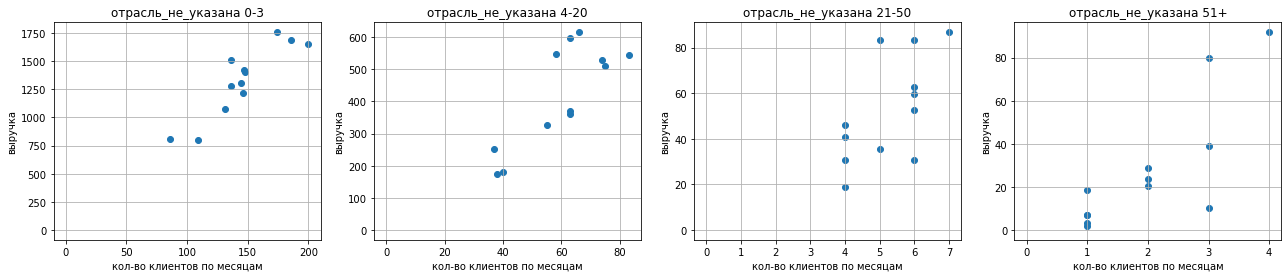

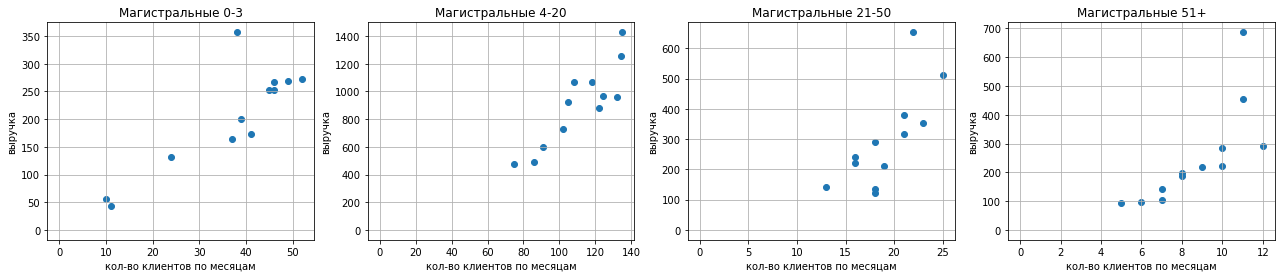

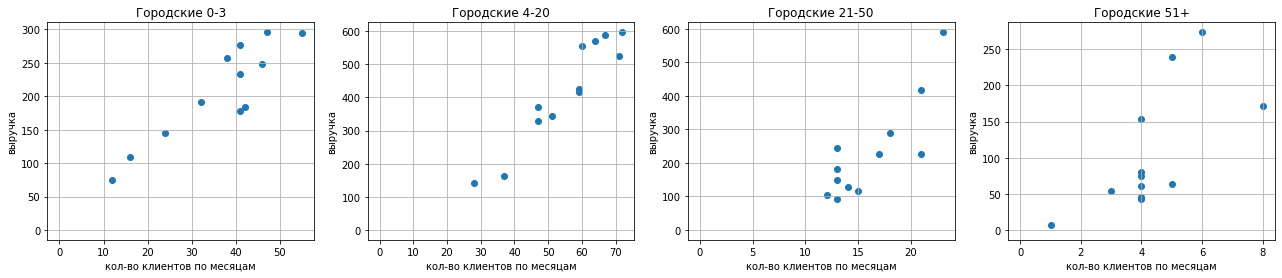

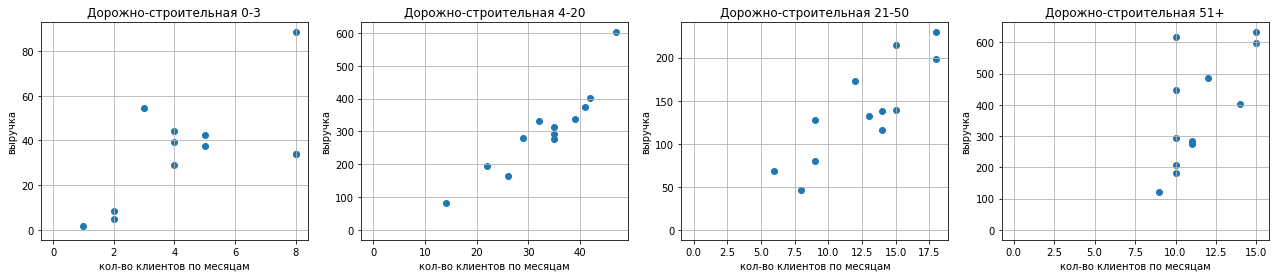

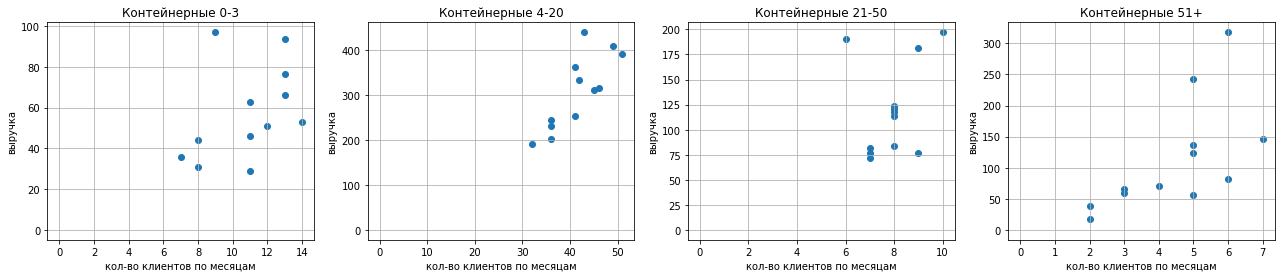

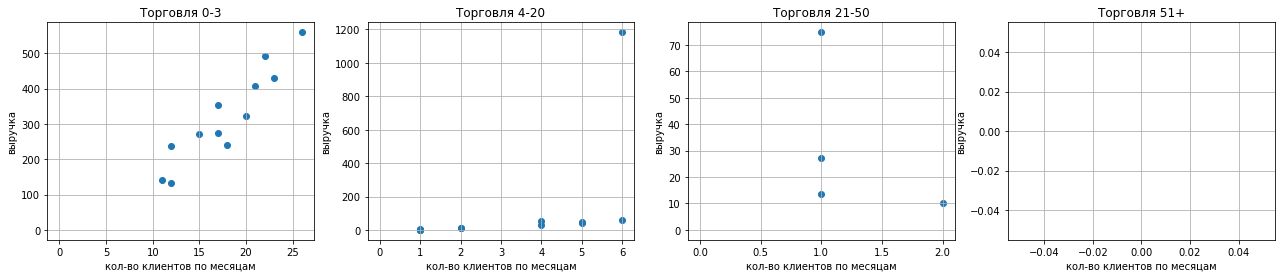

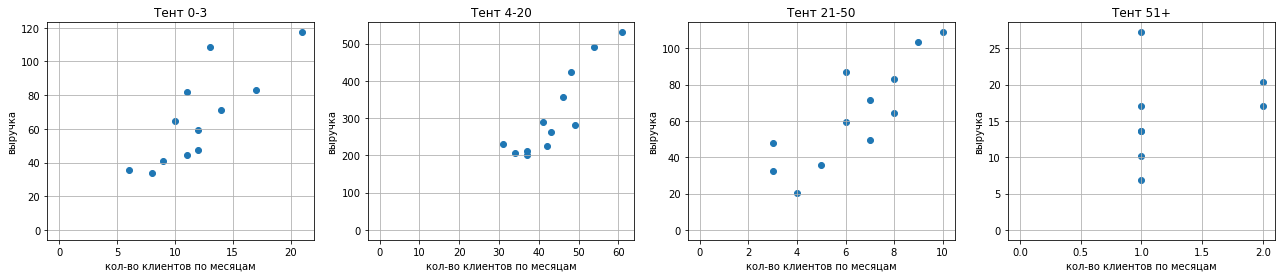

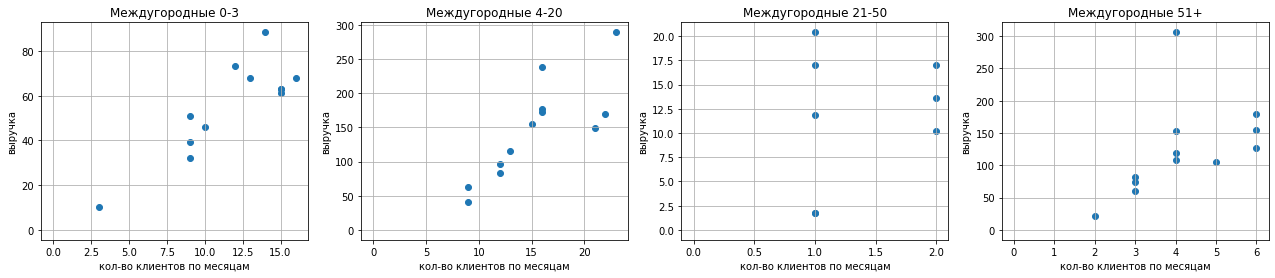

In [63]:
for num, name in enumerate(tmp0['Отрасль'][:10], start=1):
    plt.figure(figsize = (22, 4))
    plt.subplot(1, 4, 1)
    draw_plot_double(name, '0-3')

    plt.subplot(1, 4, 2)
    draw_plot_double(name, '4-20')

    plt.subplot(1, 4, 3)
    draw_plot_double(name, '21-50')

    plt.subplot(1, 4, 4)
    draw_plot_double(name, '51+')
    
    plt.show()

#### 3.1. Вывод по задаче 3  <a class='anchor' id='end_task3'>

##### Для разработки порядка(плана) действий для конкретной отрасли необходимо более детальное изучение бизнес-модели(в т.ч. для конкретной отрасли) и других условий.


##### Предоставленные данные позволяют сделать некоторые выводы.
##### Возьмем ТОП-3 отраслей для анализа.



#### Отрасль "Ритейл".
Имеет наибольшую выручку среди всех отраслей и занимает 5-е место по количеству клиентов. Общее количество клиентов неравномерно приростает до 9-го месяца(сентябрь, 3 квартал), а затем равномерно уменьшается до конца года. Пик роста количества клиентов приходится на 3, 6, 9 месяцы (конец 1, 2, 3 кварталов). 4-й квартал наихудший квартал по выручке среди кварталов.

По сегментам:
* Больше всего клиентов в данной отрасли из сегмента '0-3' по размеру парка. Рост выручки по отношению к росту количества клиентов в сегменте '0-3' более линеен по сравнению с другими сегментами и смещен в сторону меньшего прироста выручки от прироста количества клиентов. Пик роста выручки и клиентов приходится на 3-й квартал.


* Среднее количество клиентов в данной отрасли из сегмента '4-20'. Наибольшая выручка приходится на 2-й квартал, однако по месяцам пик выручки приходится на 9-й месяц. 3-й квартал уступает по выручке 2-му кварталу ввиду просадки по выручке в 8-м месяце(3 квартал) при устойчивом потоке клиентов.


* Малое количество клиентов в данной отрасли из сегмента '21-50'. Наибольшая выручка приходится на 2-й квартал при том, что в 5-м месяце наблюдается один из самых низких показалей выручки. Затем поквартально происходит снижение выручки и количества клиентов до конца года. Рост выручки по отношению к росту количества клиентов не имеет линейной связи.


* Данных по отрасли из сегмента '51+' крайне мало для изучения.

#### --------------------------------------------------------------------------------------------------------------

#### Отрасль "Самосвалы".
Имеет второе место по выручке среди всех областей и занимает 3-е место по количеству клиентов. Общее количество клиентов равномерно приростает с 3-го месяца(конец 1-го квартала) до 6-го месяца(конец 2-го квартала), затем количество держится в узком диапазоне до 10-го месяца(начало 1-го квартала) и резко снижается в середине 4 квартала. Пик роста количества клиентов приходится на 6, 9 месяцы(конец 2, 3 кварталов), а также на 1-й месяц (начало 1 квартала) при том, что 4-й квартала наихудший квартал по выручке среди кварталов.

По сегментам:
* Среднее количество клиентов в данной отрасли из сегмента '0-3'. Рост выручки по отношению к росту количества клиентов в сегменте '0-3' более линеен и смещен в сторону большего прироста выручки от прироста количества клиентов. Пик роста выручки и клиентов приходится на 2-й квартал, затем прирост выручки и клиентов немного снижается в 3-м квартале. 


* Больше всего клиентов в данной отрасли из сегмента '4-20'. Рост выручки по отношению к росту количества клиентов в сегменте '4-20' имеет большую линейность по сравнению с сегментом '0-3' и меньшее смещение. В данном сегменте более тесная поквартальная взаимосвязь между изменением объема клиентов и выручкой. Рост выручки неравномерно растет по месяцам с 4-го по 9-й месяц и равномерно растет поквартально до конца 3-го квартала(9-й месяц). Пик клиентов приходится на 3-й квартал.


* Малое количество клиентов в данной отрасли из сегмента '21-50', в котором менее выраженная линейная связь, по сравнению с сегментами '0-3' и '4-20', а также более выраженное смещение в сторону меньшего прироста выручки от прироста количества клиентов. Данный сегмент более чувствителен к приросту количества клиентов. Пик роста выручки и клиентов приходится на конец 3-го квартала.


* Незначительное количество клиентов в данной отрасли из сегмента '51+'. В основном прирост количества клиентов приходится на начало года и конец года(начало 1-го квартала и 10, 11, 12 месяцы 4-го квартала). Рост выручки приходится на 3-й квартал при том, что количество клиентов уменьшается с конца года - начала года до 3-го квартала. 

#### --------------------------------------------------------------------------------------------------------------

#### Отрасль "отрасль_не_указана".
Имеет третье место по выручке среди всех областей и занимает 1-е место по количеству клиентов. Общее количество клиентов неравномерно приростает с 4-го месяца(начало 2-го квартала) до 10-го месяца(начало 4-го квартала), затем количество в середине 4-го квартала резко снижается. Пик роста количества клиентов приходится на 6, 10 месяцы(конец 2 квартала, начало 4 квартала), а также на 1-й месяц(начало 1-го квартала) при том, что 4-квартал наихудший среди всех кварталов.

По сегментам:
* Больше всего клиентов в данной отрасли из сегмента '0-3' по размеру парка. Рост выручки по отношению к росту количества клиентов в сегменте '0-3' более линеен и имеет больший разброс количества клиентов по сравнению с другими сегментами, а также смещен в сторону большего прироста выручки от прироста количества клиентов. Имеет пик роста выручки и клиентов в 3-м квартале.


* Среднее количество клиентов в данной отрасли из сегмента '4-20', в котором также наблюдается выраженная линейная связь между приростом выручки и приростом количества клиентов, однако линейное смещение наблюдается как в сторону большего прироста выручки от прироста количества клиентов, так и меньшего прироста выручки от прироста количества клиентов. Наибольшее количество клиентов наблюдается в 3-м квартале, но наибольная выручка наблюдается в 1-м квартале, а затем неравномерно поквартально уменьшается.


* Малое количество клиентов в данной отрасли из сегмента '21-50'. В данном сегменте пик помесячного роста выручки приходится на 6-й месяц(конец 2-го квартала), а поквартальный пик роста приходится на 3-й квартал. Пик помесячного роста клиентов приходится также на 6-й месяц(конец 2-го квартала), однако поквартально количество клиентов плавно уменьшается до конца года. В данном сегменте небольшое количество клиентов, которые более равномерно распределены по месяцам по сравнению с сегментами '0-3' и '4-20'.


* Незначительное количество клиентов в данной отрасли из сегмента '51+'. Пики роста выручки и роста количества клиентов приходятся на 2 и 4 кварталы. Минимальное количество клиентов наблюдается 4 месяца подряд с 1-го месяца 1-го квартала до 4-го месяца 2-го квартала.

----------- 

####  Для выработки дальнейших выводов предлагается общий порядок действий:
- Изучение клиентов из разных отраслей, формирование образа клиента(его потребностей и т.д);
- Изучение специфики бизнес-процессов компаннии, в том числе логистики;
- Изучение ценовой политики для клиентов разных сегментов в отрасли;
- Изучение охвата клиентов, посещаемости ресурсов, конверсии по отраслям;
- Изучения влияния внешних факторов на исследуемые показатели компании;
- Изучение и выявление закономерностей в данных для обоснования целевой переменной в данных;
- Изучение потребительского поведения и возможности внедрения рекомендательных систем, uplift-моделирования.


Без изучения соответствующих вопросов, связанных с ведением бизнеса, разработка порядка действий(плана) по отраслям нецелесообразна, поскольку может иметь слишком теоретический характер.

<!-- Для ценовая политика:
Для исследования рынка:
Для логистики
Для дополнительного увеличения продаж
Для инноваций -->

--------

### 4. Дополнительное исследование данных с помощью ML моделей <a class='anchor' id='task4'>

In [33]:
my_train_lgbm = df.copy()
# преобразуем все в категории для lgbm
for feature in my_train_lgbm.select_dtypes(include=[np.object]).columns.tolist():
    my_train_lgbm[feature] = pd.Series(my_train_lgbm[feature], dtype="category")

In [34]:
X1 = my_train_lgbm.drop(['Итого'], axis=1)
y1 = my_train_lgbm['Итого']

X_train1, X_part1, y_train1, y_part1 = train_test_split(
    X1, y1, train_size=0.6, random_state=99, stratify=my_train_lgbm['Месяц'])

X_valid1, X_test1, y_valid1, y_test1 = train_test_split(
    X_part1, y_part1, train_size=0.5, random_state=99, stratify=X_part1['Месяц'])

In [35]:
X_train1.shape, X_valid1.shape, X_test1.shape

((9454, 7), (3151, 7), (3152, 7))

In [36]:
params_lgbm = {
#     "boosting_type": "gbdt",
#     "objective": "binary",
    "metric": "mse",
#     "learning_rate": 0.1,
    "n_estimators": 1500,
    "n_jobs": 6,
    "seed": 27
}

In [37]:
model_lgbm = LGBMRegressor(**params_lgbm)
model_lgbm.fit(
    categorical_feature=my_train_lgbm.select_dtypes(include=[np.object]).columns.tolist(),
    X=X_train1,
    y=y_train1,
    eval_set=[(X_train1, y_train1), (X_valid1, y_valid1)],
    early_stopping_rounds=25,
    eval_metric="mse",
    verbose=25
)

[25]	training's l2: 532.642	valid_1's l2: 464.116
[50]	training's l2: 483.391	valid_1's l2: 443.481
[75]	training's l2: 452.642	valid_1's l2: 430.996
[100]	training's l2: 432.052	valid_1's l2: 423.594
[125]	training's l2: 412.821	valid_1's l2: 416.602
[150]	training's l2: 395.181	valid_1's l2: 408.749
[175]	training's l2: 380.248	valid_1's l2: 405.273
[200]	training's l2: 365.19	valid_1's l2: 402.419
[225]	training's l2: 354.467	valid_1's l2: 402.449


LGBMRegressor(metric='mse', n_estimators=1500, n_jobs=6, seed=27)

In [38]:
mean_squared_error(y_test1, model_lgbm.predict(X_test1)), r2_score(y_test1, model_lgbm.predict(X_test1))

(626.861007530643, 0.25407329625469)

In [39]:
# catboost

In [40]:
my_train_ctb = df.copy()

for ii in my_train_ctb.select_dtypes(include=['object', 'category']).columns.tolist():
    my_train_ctb[ii] = my_train_ctb[ii].astype(str)

cat_features_idx = np.where(my_train_ctb.drop('Итого', axis=1).dtypes == 'object')[0].tolist()
cat_features_idx

[0, 3, 4, 6]

In [41]:
X2 = my_train_ctb.drop(['Итого'], axis=1)
y2 = my_train_ctb['Итого']

X_train2, X_part2, y_train2, y_part2 = train_test_split(
    X2, y2, train_size=0.6, random_state=99, stratify=my_train_ctb['Месяц'])

X_valid2, X_test2, y_valid2, y_test2 = train_test_split(
    X_part2, y_part2, train_size=0.5, random_state=99, stratify=X_part2['Месяц'])

In [42]:
X_train2.shape, X_valid2.shape, X_test2.shape

((9454, 7), (3151, 7), (3152, 7))

In [43]:
params_ctb = {
    "n_estimators": 1500,
#     "loss_function": "Logloss",
    "eval_metric": "R2",
    "task_type": "CPU",
#     "max_bin": 20,
    "verbose": 100,
#     "max_depth": 3,
#     "l2_leaf_reg": 100,
    "early_stopping_rounds": 25,
#     "thread_count": 6,
    "random_seed": 27
}
model_ctb = CatBoostRegressor(**params_ctb)
model_ctb.fit(X_train2, y_train2, eval_set=[(X_train2, y_train2), (X_valid2, y_valid2)], cat_features=cat_features_idx)

Learning rate set to 0.056579
0:	learn: 0.0115916	test: 0.0115404	test1: 0.0128072	best: 0.0128072 (0)	total: 91.3ms	remaining: 2m 16s
100:	learn: 0.2625564	test: 0.3067115	test1: 0.3125554	best: 0.3125554 (100)	total: 3.9s	remaining: 54s
200:	learn: 0.2981643	test: 0.3280896	test1: 0.3292062	best: 0.3292365 (198)	total: 7.4s	remaining: 47.8s
300:	learn: 0.3257818	test: 0.3407536	test1: 0.3446415	best: 0.3447634 (299)	total: 11s	remaining: 43.9s
Stopped by overfitting detector  (25 iterations wait)

bestTest = 0.3507397963
bestIteration = 372

Shrink model to first 373 iterations.


In [44]:
mean_squared_error(y_test2, model_ctb.predict(X_test2)), r2_score(y_test2, model_ctb.predict(X_test2))

(659.0972851446521, 0.21571407465250547)

#### 4.1. Вывод по дополнительному исследованию  <a class='anchor' id='end_task4'>

- В данной задаче исследовалась зависимость целевой переменной (итоговая сумма, столбец "Итого") от других переменных, имеющихся в предоставленной таблице, которая не дополнялась новыми фичами.


- Метрика R2 на трейне и на тесте получилась очень низкой и ошибка MSE получилась слишком высокой, это говорит о том, что наблюдения имеют плохую объясняющую способность для целевой переменной.


- Для эффективного исследования зависимостей необходим более качественный датасет.

-------

### 5. Дополнительное исследование данных и построение простой одноуровневой рекомендательной системы <a class='anchor' id='task5'>

In [45]:
df['Код клиента'].nunique()

6313

In [46]:
# В дальнейшем можно перенести функции в загружаемые модули. Здесь размещено для простоты поиска.

#metrics
def calc_precision(df_data, top_k):
    """ Расчет точности на предоставленных данных.
    df_data - данные, где должны быть столбцы с user_id, actual_col(реальные покупки покупателя): list, recommendation: list;
    top_k - значение для расчета точности actual_col, recommendation.
    """
    for col_name in df_data.columns[2:]:
        yield col_name, df_data.apply(lambda row: precision_at_k(row[col_name], row[ACTUAL_COL], k=top_k), axis=1).mean()

def give_top_popular_field_segment(user, topn=5):
    all_list = []
    field = result_matcher.loc[result_matcher['Код клиента'] == user]['Отрасль'].tolist()[0]
    segment = result_matcher.loc[result_matcher['Код клиента'] == user]['Сегмент'].tolist()[0]
    pp = result_matcher.loc[(result_matcher['Отрасль'] == field) & (result_matcher['Сегмент'] == segment)]['actual'].values

    for ii in range(len(pp)):
        locl = list(pp[ii])
        all_list += list(locl)

    return pd.Series(all_list).value_counts()[:topn].index.tolist()

In [47]:
ITEM_COL = 'Месяц'
USER_COL = 'Код клиента'
ACTUAL_COL = 'actual'

# N = Neighbors
N_PREDICT = 5

In [48]:
data_df = df.reset_index().copy()
data_df.head(2)

index  Код клиента  Размер парка  Месяц   Итого    Отрасль Сегмент  \
0      0  00-00049327             4      2  1020.0   Торговля    4-20   
1      1  00-00005692            24      9   642.6  Самосвалы   21-50   

   Номер_сегмента Квартал  
0               2       1  
1               3       3

In [49]:
# удалим тех, кто обращался 1 раз
hh = data_df.groupby('Код клиента', as_index=False).count()[['Код клиента', 'index']]
list_del_clients = hh.loc[hh['index'] < 2]['Код клиента'].tolist()
data_df = data_df.loc[~data_df['Код клиента'].isin(list_del_clients)]
data_df['Код клиента'].nunique()

2881

In [50]:
fffff = data_df['Код клиента'].unique().tolist()
clients_list = []
for ii in range(4000):
    cli = random.choice(fffff)
    if cli not in clients_list:
        clients_list.append(cli)
        
# берем данные для тренировки matching модели
data_train = data_df.loc[data_df['Код клиента'].isin(clients_list)]
# берем данные для тренировки модели
data_test = data_df.loc[~data_df['Код клиента'].isin(clients_list)]

In [51]:
data_train.shape, data_test.shape

((9273, 9), (3052, 9))

In [52]:
data_train['Код клиента'].nunique(), data_test['Код клиента'].nunique()

(2192, 689)

In [53]:
result_matcher = data_train.groupby(USER_COL)[ITEM_COL].unique().reset_index()
result_matcher.columns=[USER_COL, ACTUAL_COL]
result_matcher.head(2)

Код клиента                                   actual
0        8275  [1, 3, 9, 10, 11, 6, 8, 7, 2, 5, 12, 4]
1       10150  [1, 11, 7, 5, 10, 2, 8, 6, 9, 12, 3, 4]

In [54]:
result_matcher = pd.merge(result_matcher, data_train.groupby(['Код клиента','Отрасль', 'Сегмент'], as_index=False).count()[['Код клиента','Отрасль', 'Сегмент']],
         how='left', on='Код клиента')
result_matcher.head(2)

Код клиента                                   actual             Отрасль  \
0        8275  [1, 3, 9, 10, 11, 6, 8, 7, 2, 5, 12, 4]  отрасль_не_указана   
1       10150  [1, 11, 7, 5, 10, 2, 8, 6, 9, 12, 3, 4]  отрасль_не_указана   

  Сегмент  
0     0-3  
1     0-3

In [55]:
%%time
result_matcher['top_popular_field_segment'] = result_matcher[USER_COL].apply(lambda x: give_top_popular_field_segment(x, 5))
result_matcher.head(2)

CPU times: total: 6.31 s
Wall time: 6.34 s


Код клиента                                   actual             Отрасль  \
0        8275  [1, 3, 9, 10, 11, 6, 8, 7, 2, 5, 12, 4]  отрасль_не_указана   
1       10150  [1, 11, 7, 5, 10, 2, 8, 6, 9, 12, 3, 4]  отрасль_не_указана   

  Сегмент top_popular_field_segment  
0     0-3          [9, 8, 2, 10, 6]  
1     0-3          [9, 8, 2, 10, 6]

In [56]:
# холодно-теплый старт
list(calc_precision(result_matcher[['Код клиента', 'actual', 'top_popular_field_segment']], 2))

[('top_popular_field_segment', 0.5084397810218978)]

In [57]:
# на тесте -----------------------------------------------------------------------------------------------

In [58]:
result_matcher_test = data_test.groupby(USER_COL)[ITEM_COL].unique().reset_index()
result_matcher_test.columns=[USER_COL, ACTUAL_COL]
result_matcher_test.head(2)

Код клиента                                   actual
0       14680  [3, 2, 7, 6, 8, 9, 11, 10, 12, 5, 4, 1]
1       14790                 [9, 2, 10, 12, 11, 8, 1]

In [59]:
result_matcher_test = pd.merge(result_matcher_test, data_test.groupby(
    ['Код клиента','Отрасль', 'Сегмент'], as_index=False).count()[['Код клиента','Отрасль', 'Сегмент']],
         how='left', on='Код клиента')
result_matcher_test.head(2)

Код клиента                                   actual             Отрасль  \
0       14680  [3, 2, 7, 6, 8, 9, 11, 10, 12, 5, 4, 1]              Ритейл   
1       14790                 [9, 2, 10, 12, 11, 8, 1]  отрасль_не_указана   

  Сегмент  
0     0-3  
1    4-20

In [60]:
ff = result_matcher[['Отрасль', 'Сегмент', 'top_popular_field_segment']]
ff = ff.drop_duplicates(subset=['Отрасль', 'Сегмент'])

result_matcher_test2 = pd.merge(result_matcher_test, ff, how='left', on=['Отрасль', 'Сегмент'])
result_matcher_test2.head(1)

Код клиента                                   actual Отрасль Сегмент  \
0       14680  [3, 2, 7, 6, 8, 9, 11, 10, 12, 5, 4, 1]  Ритейл     0-3   

  top_popular_field_segment  
0          [9, 6, 10, 7, 3]

In [61]:
# фильтрация ораслей и сегментов, удаление нулевых(иначе выдаст ошибку)

result_matcher_test2 = result_matcher_test2.loc[
    (result_matcher_test2['Отрасль'].isin(result_matcher['Отрасль'].unique().tolist())) &
    ( result_matcher_test2['Сегмент'].isin(result_matcher['Сегмент'].unique().tolist()) ) ]

#нулевые
print(result_matcher_test2['top_popular_field_segment'].isna().sum())
result_matcher_test2.dropna(inplace=True)

13


In [62]:
list(calc_precision(result_matcher_test2[['Код клиента', 'actual', 'top_popular_field_segment']], 2))

[('top_popular_field_segment', 0.4511834319526627)]

#### 5.1. Вывод по дополнительному исследованию  <a class='anchor' id='end_task5'>

- В данной задаче исследовалась возможность создания рекомендательной системы для определения месяца, в котором клиент снова обратится в компанию.

- Исследовались наиболее популярные у клиентов из разных отраслей и разных сегментов месяцы, в которых клиенты чаще всего обращаются в компанию. Затем эти месяцы рекомендованы клиентам. В исследовании применена простая одноуровневая рекомендательная модель без дополнительных библиотек.

- Предложенная метрика precision@2 получилась достаточно высокой(на трейне 0.51, на тесте 0.40), это говорит о том, что предложенная модель может быть полезной в случае разработки рекомендаций для клиента(например, отправки дополнительного уведомления клиенту в мобильном приложении в рекомендованный месяц).

- Исследование данных в целях формирования рекомендаций не ограничивается предложенными и реализованными действиями, а лишь является неким baseline в данной постановке задачи.
